<a href="https://colab.research.google.com/github/mareloraby/Sentiment-Arcs/blob/main/Time%20Series%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect to goole drive to load data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tensorflow
!pip install calplot
!pip install langdetect
!pip install statsmodels==0.12.1


from IPython.display import clear_output
clear_output()

In [3]:
import os
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
clear_output()

## Prepare BERT fine-tuned model

In [4]:
def text_preprocessing(text):

    import re

    text = re.sub(r'\\(?!u)','',text)

    # Remove em dash
    text = re.sub(r'—|—', ' ', text)

    # Remove all occurances of "
    text = re.sub(r'\"|“|”|…'," ",text)
    text = re.sub(r'\’',"\'",text)
    text = re.sub(r'\‘',"\'",text)

    # Replace emoticons and emojis

    text = re.sub(r':P|:-P|😂|🤣',' joking ',text)

    text = re.sub(r'<3|< 3|❤️|💖|😍|💕|😘|💕|💝|💗|💜|💙|🖤|💚|💛|🤍|❤',' love ', text) 

    text = re.sub(r'[😁😃😄😆😊😸😺😊😀😋🥰☺️]','  Happy . ', text)
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))','  Happy . ', text)
    text = re.sub(r'(:\s?D|:-?D|x-?D)','  Happy . ', text)


    text = re.sub(r'[😥😣😓😔😕☹️🙁😖😞😟😢😭😩😵😡😿😫🤢😨😱🤬]','  Sad . ', text)
    text = re.sub(r'(:\(|:-\(|\):|\)-:)','  Sad . ', text)
    text = re.sub(r'(:,\(|:\'\(|:"\()','  Sad . ', text)
    
    # Remove every other emoji
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    text = (emoji_pattern.sub(r'', text)) # no emoji

    text = re.sub('[\U0001F600-\U0001FFFF]'," ", text)
    text = re.sub('[\U0001F300-\U0001F5FF]'," ", text)

    #remove @usermentions
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Remove URLs
    text = re.sub(r'((https?://[^\s]+)|(www\.[^\s]+))','',text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    
    # Remove hash (#) symbol
    text = re.sub(r'#', ' ', text).strip()

    # Remove trailing dots
    text= re.sub("[.]+", ". ",text)    

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:
#Connect to GPU

import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


Tokenizer

In [7]:
# Load the BERT tokenizer

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Specify max length to trancuate/pad to
MAX_LEN = 95 

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:

        # encode_plus will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text_preprocessing(r""+sent),   # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True,     # Return attention mask
            
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [8]:
#BERT Classifier architecture


%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class

# BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size on the output. 
# The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.
# We create a single-hidden-layer feed-forward neural network with 0.3 dropout as our classifier.

class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-cased',return_dict=False)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(H, D_out)
        )


    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 34.2 ms, sys: 2.45 ms, total: 36.6 ms
Wall time: 38 ms


In [9]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [10]:
#Load model
modeLoaded = torch.load('/content/drive/MyDrive/NLP/TweetEval/1-3ep0.2(T1nodot)')

Testing on user input

tensor([0], device='cuda:0')
tweet text: This is a fine mess
Sentiment  : negative


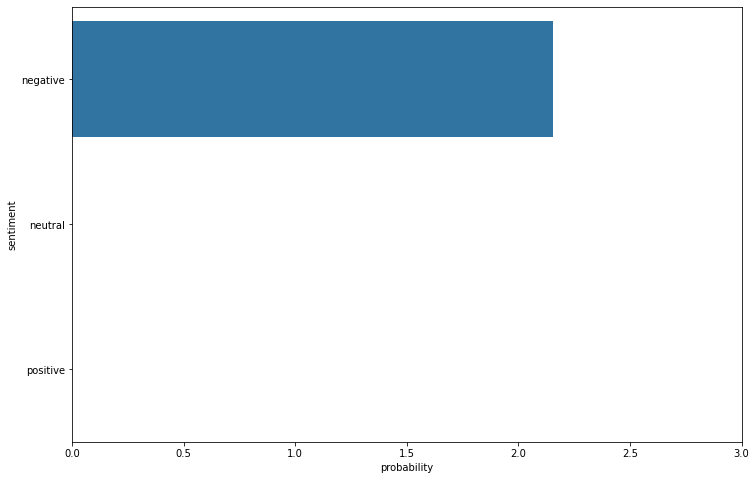

In [23]:
#@title Write your tweet... { run: "auto", vertical-output: true, form-width: "70%", display-mode: "form" }
my_input = "This is a fine mess" #@param {type:"raw"}
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

MAX_LEN = 85
class_names = ['negative', 'neutral', 'positive']

encoded_review = tokenizer.encode_plus(
  text_preprocessing(my_input),
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = modeLoaded(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(prediction)
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': output.detach().cpu().numpy()[0]
})


print(f'tweet text: {my_input}')
print(f'Sentiment  : {class_names[prediction]}')


sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 3]);


## Scaling the softmax output to cover a range between -1 to 1 to treat as sentiment intensity scores
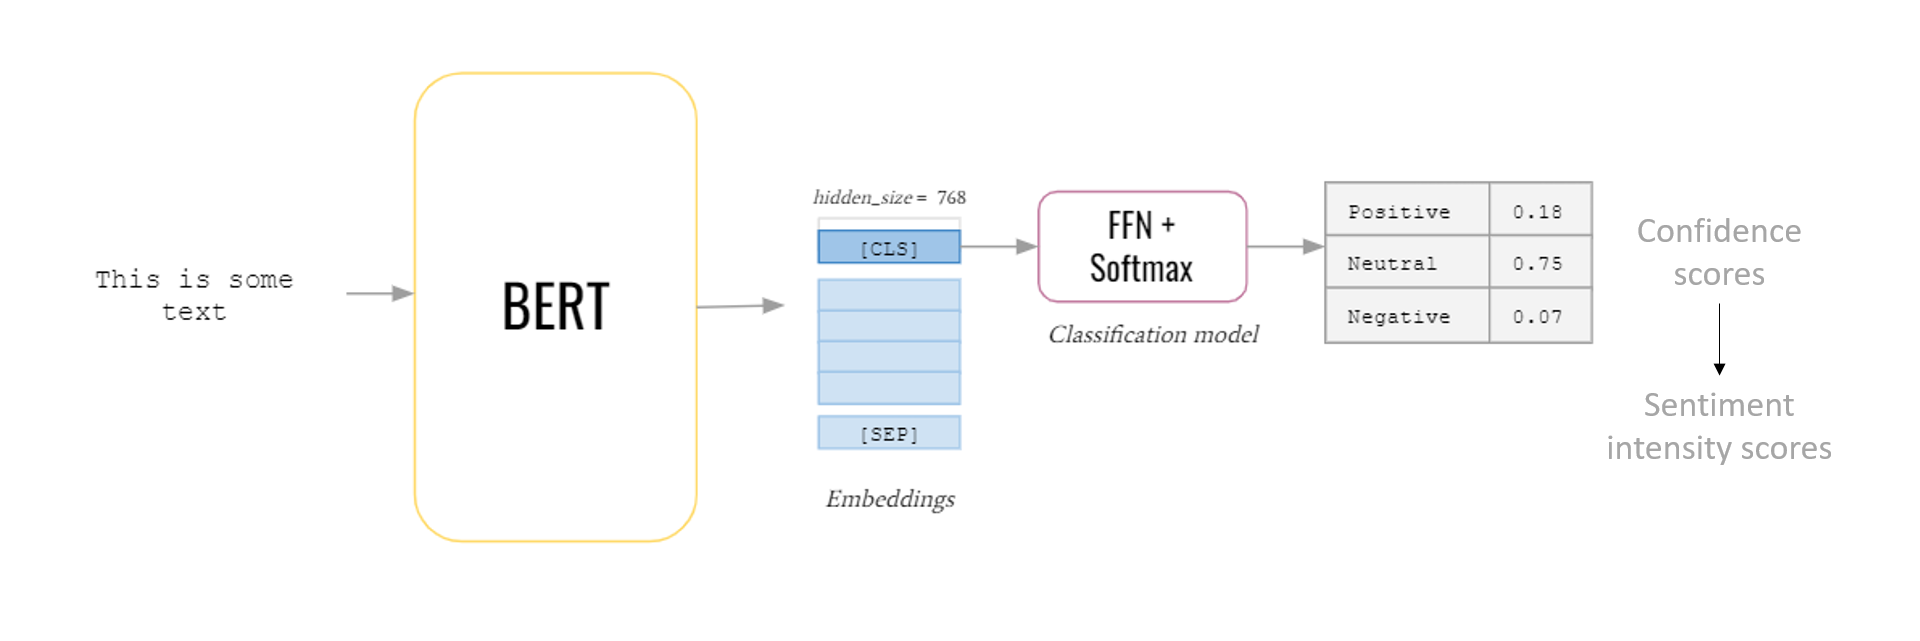



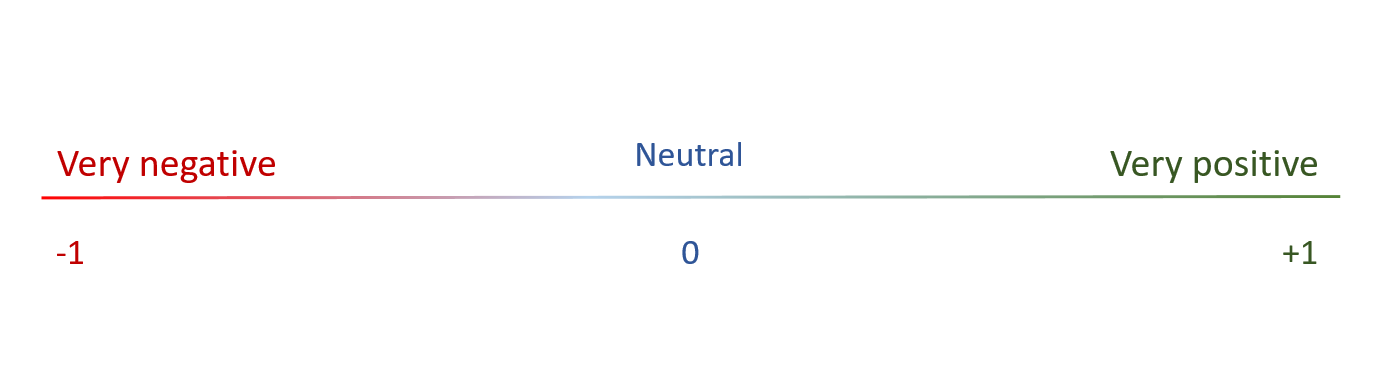

In [24]:
import matplotlib.pyplot as plt

def split3(df): 

  pos = df[df['label'] == 2]
  neg = df[df['label'] == 0]
  neu = df[df['label'] == 1]

  return neg,neu,pos

def normalizeScores(df):

  neg0,neu0,pos0 = split3(df)
  
  pos0['score_norm'] = pos0.norm01 
  neu0['score_norm'] = 0.0  
  neg0['score_norm'] = -1*(neg0.norm01)  

  appended = pos0.append(neu0,ignore_index=True).append(neg0,ignore_index = True)
  appended.sort_values('Datetime',ignore_index=True, inplace = True)

  return appended

# Time Series Analysis of COVID-19 Tweets

Application of BERT on the Covid-19 tweets fron Feb 2020 till June 2021 was done over multiple steps:

1) Load tweets from each month as such:
  

```
import json
import pandas as pd


with open('/content/drive/MyDrive/NLP/COVID19data/02Feb2020/feb2020_0.csv', 'r',encoding="utf-8",) as f:
    data = f.read()  
    data = data.split("\n") 
    # print(data[1])
    data2 = []
    for d in data:
        j = json.loads(d)
        data2.append(j)

with open('tweets2.json', 'w') as f:
    json.dump(data2, f)

data = json.load(open('tweets2.json',encoding="utf-8"))
feb0 = pd.DataFrame(data)

```

2) Pre-processing and then the prediction of sentiments of each tweet



```
dffeb09,probs = preprocess_predict(feb09)
dffeb09 = dffeb09.reset_index()
```

Where ```preprocess_predict``` is defined as follows:


```
class_names = ['negative', 'neutral', 'positive']
MAX_LEN = 85

from langdetect import detect
def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False


def extractDate(df):
   df = df[df['full_text'].apply(is_en)]
   df["created_at"] = df["created_at"].apply(lambda x : x.replace("+0000 ",""))
   df['Datetime'] = pd.to_datetime(df['created_at'],format="%a %b %d %H:%M:%S %Y")
   data = df[['Datetime','full_text']]
   return data


from torch.utils.data import TensorDataset, DataLoader

def preprocess_predict(df):

  df = extractDate(df)\

  # Run function `preprocessing_for_bert` on the train set and the validation set
  print('Tokenizing data...')
  text_inputs, text_masks = preprocessing_for_bert(df.full_text)

  # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
  batch_size = 16

  # Create the DataLoader for our test set
  test_dataset = TensorDataset(text_inputs, text_masks)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  # predictions array
  probs = bert_predict(modeLoaded, test_dataloader)

  tensorprobs = torch.from_numpy(probs)
  tensorlabels = torch.max(tensorprobs, dim=1)

  df['label'] = tensorlabels[1].cpu().numpy()
  df['norm01'] = tensorlabels[0].cpu().numpy()

  return df




```



3) After the application of BERT on all tweets of all months, They are saved in one file under the name "allTweetstilljune21100.csv"

For more details, feel free to contact me :)

In [25]:
allTweets = pd.read_csv("/content/drive/MyDrive/NLP/COVID19data/allTweetstilljune21100.csv",  lineterminator='\n') 
allTweets['Datetime'] = pd.to_datetime(allTweets['Datetime'])
allTweets2= normalizeScores(allTweets)
allTweets2 = allTweets2.set_index('Datetime')
allTweets = allTweets2

clear_output()

allTweets

,index,full_text,label,norm01,score_norm
Datetime,,,,,
2020-02-01 00:00:00,69354,Pointing to the outbreak of the coronavirus in...,0,0.655362,-0.655362
2020-02-01 00:00:28,82543,Dalton man wears face mask after coronavirus i...,1,0.882608,0.000000
2020-02-01 00:00:35,96606,Coronavirus lies are rife on social media. Her...,0,0.941583,-0.941583
2020-02-01 00:01:01,6963,@CassandraRules I think its due to their coron...,0,0.980004,-0.980004
2020-02-01 00:01:34,58907,6/The truth is that the OVERWHELMING majority ...,0,0.951164,-0.951164
...,...,...,...,...,...
2021-06-30 23:56:00,53748,TA CAINDO FML https://t.co/O3SKpPupc4,1,0.822455,0.000000
2021-06-30 23:56:25,83260,@ShuttleMrGeo Not true.\nIt has been isolated....,0,0.753796,-0.753796
2021-06-30 23:56:41,31144,What are the odds of dying form COVID19 Vs sta...,0,0.933541,-0.933541


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


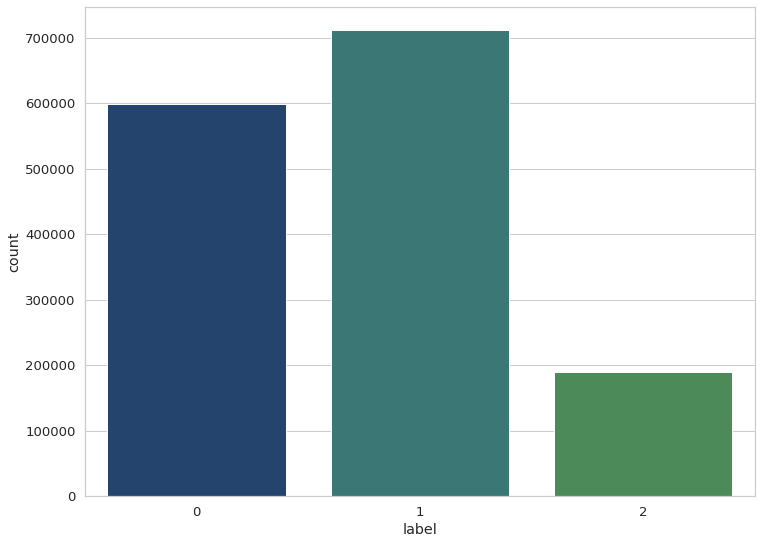

In [26]:
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 9
sns.set(style='whitegrid', palette='gist_earth', font_scale=1.2)
sns.countplot(allTweets.label)

### Count of tweets per day

In [27]:
tweetCounts = allTweets.resample('1D').count()

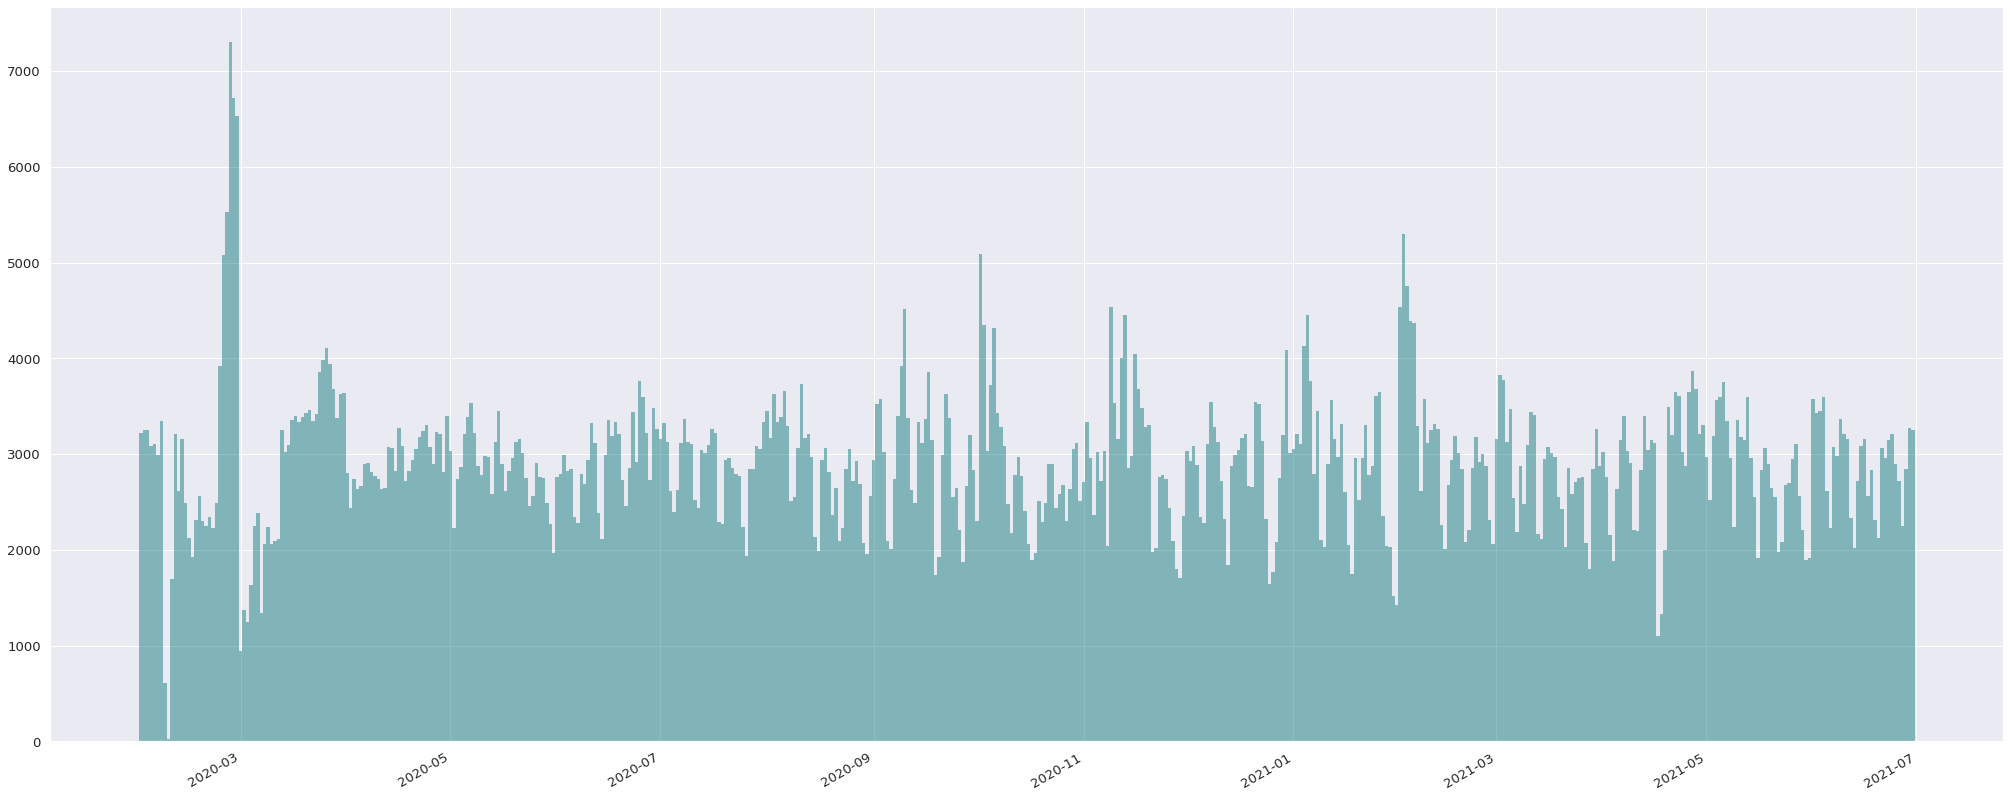

In [28]:
import seaborn as sns

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(35,15))
width = np.diff(tweetCounts.index).min()
ax.bar(tweetCounts.index, tweetCounts.full_text, alpha=0.5,color=(0.1,0.5,0.5),width=width,linewidth=0)
# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()


In [29]:
allTweetsCOVID = allTweets[['full_text','score_norm']]

### 1. Trailing moving average.

In [38]:
rolled = allTweetsCOVID
rolled['rolling'] = rolled['score_norm'].rolling(window=450).mean()

clear_output()

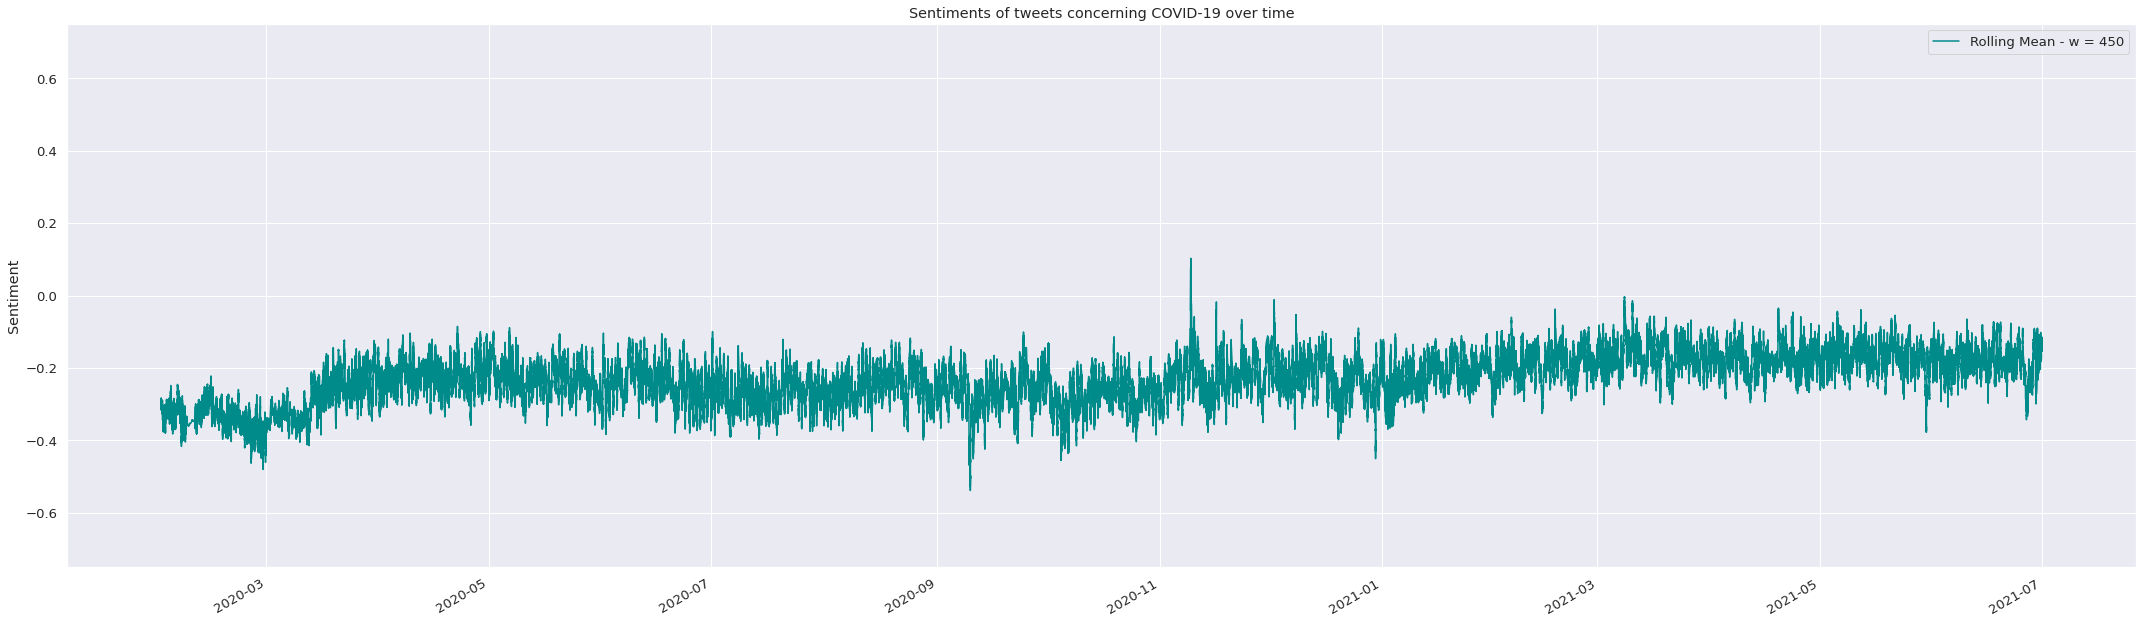

In [39]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
ax.plot(rolled.index,rolled['rolling'], color ='darkcyan', label='Rolling Mean - w = 450')
ax.set(title='Sentiments of tweets concerning COVID-19 over time', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

In [40]:
grouped = allTweetsCOVID.resample('1D')
allgrouped = grouped.mean().reset_index()
allgrouped["score_norm"] = pd.to_numeric(allgrouped["score_norm"])
allgrouped

,Datetime,score_norm,rolling
0,2020-02-01,-0.323424,-0.323949
1,2020-02-02,-0.324426,-0.326208
2,2020-02-03,-0.312547,-0.310759
3,2020-02-04,-0.329763,-0.330050
4,2020-02-05,-0.299576,-0.304099
...,...,...,...
511,2021-06-26,-0.265507,-0.256968
512,2021-06-27,-0.229604,-0.236435
513,2021-06-28,-0.175108,-0.186892
514,2021-06-29,-0.199421,-0.192450


### 2. Taking the mean of daily sentiments.

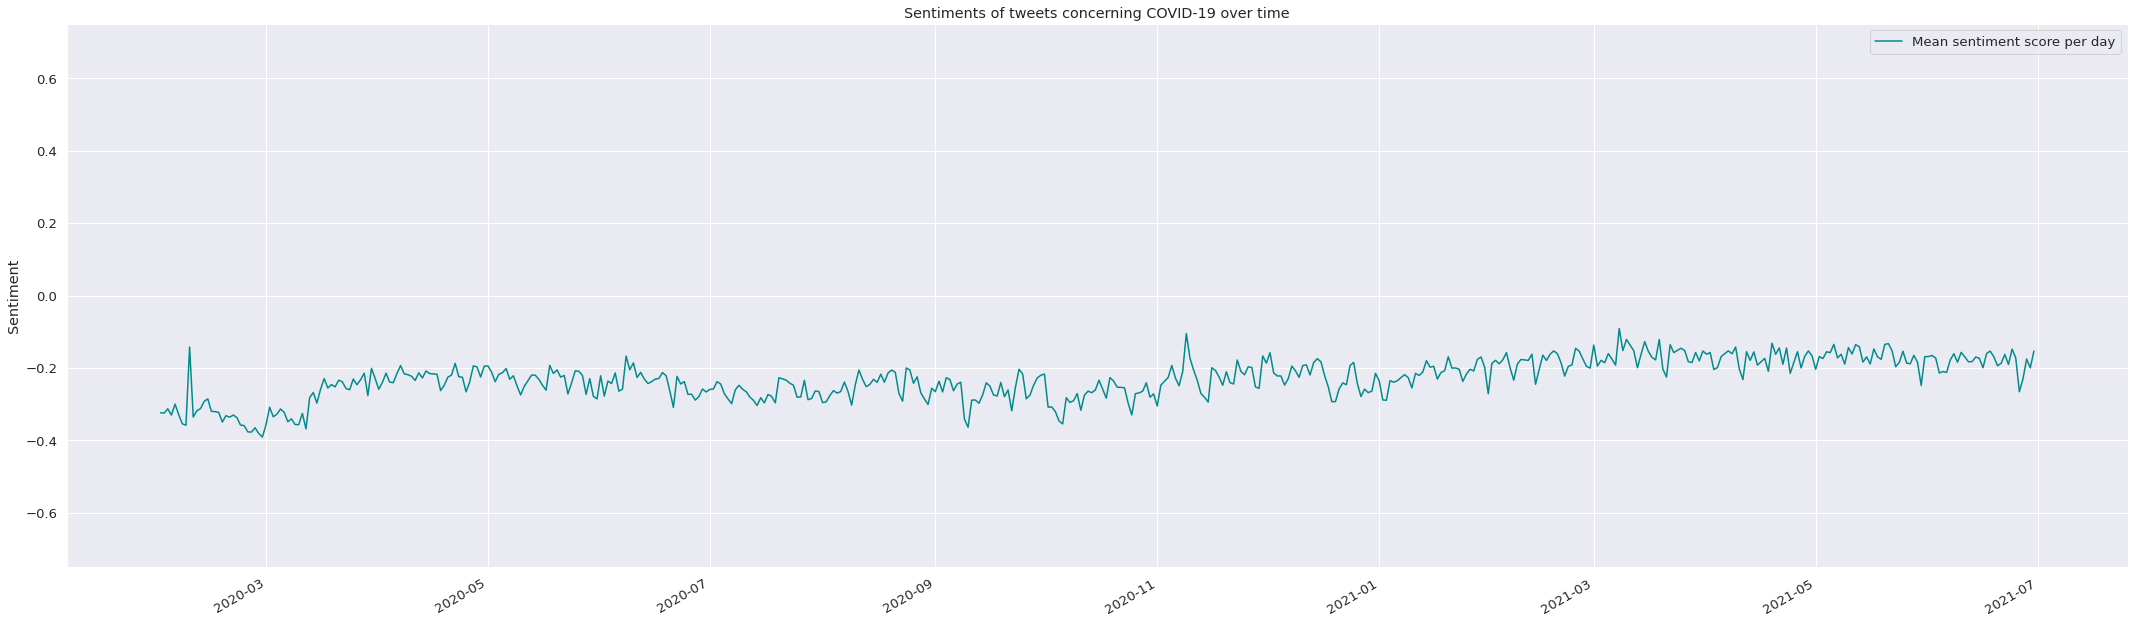

In [ ]:

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
ax.plot(allgrouped.Datetime,allgrouped.score_norm,color='darkcyan', label='Mean sentiment score per day')


ax.set(title='Sentiments of tweets concerning COVID-19 over time', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

### 3. Take the mean of daily sentiments then apply Savitzki-Golay filter.

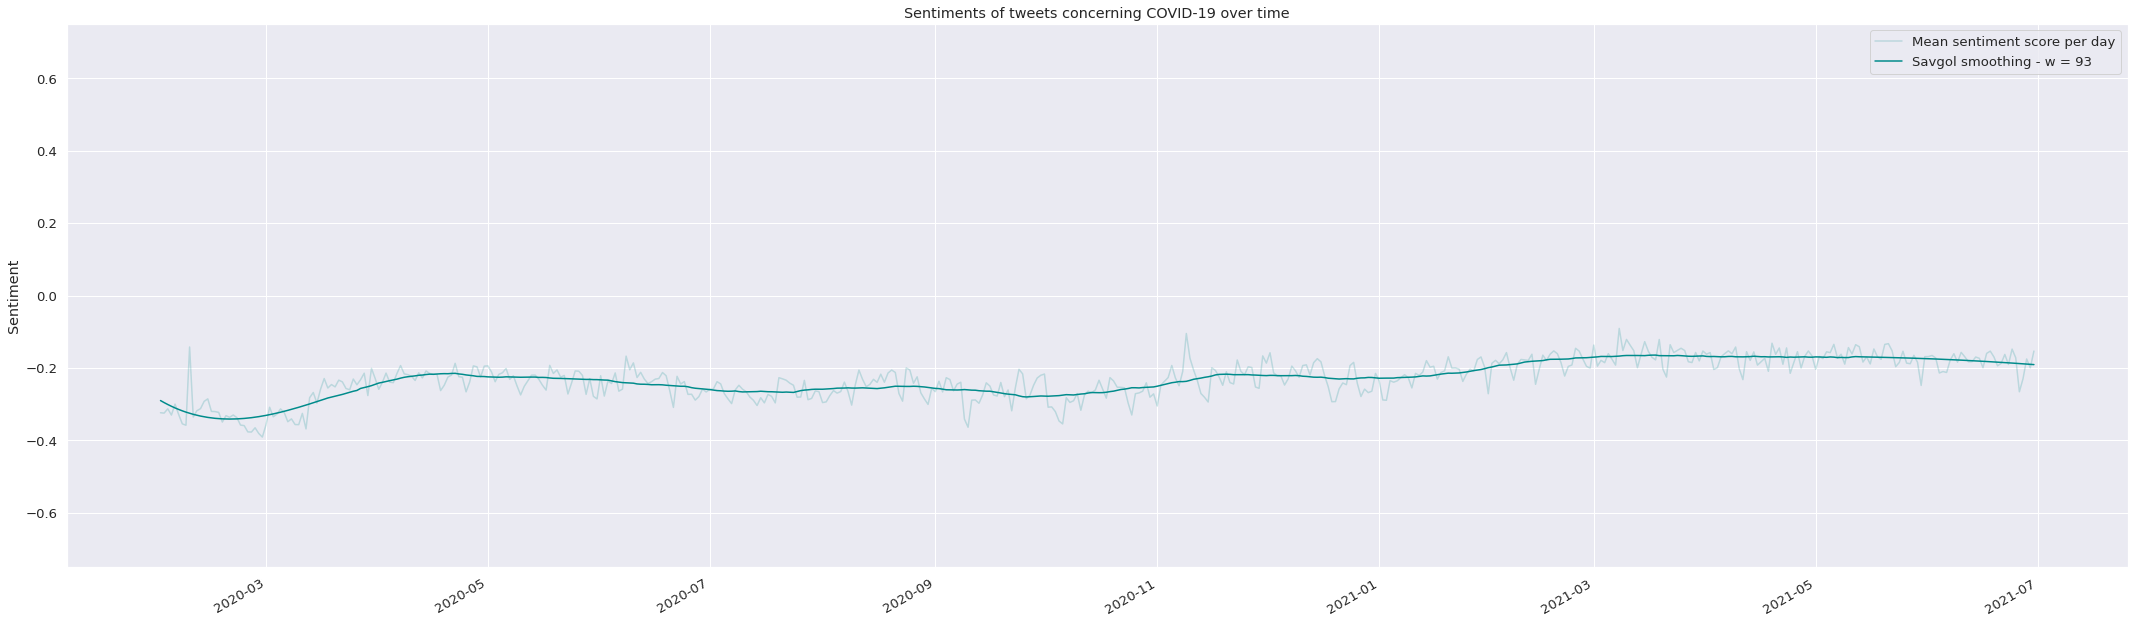

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
ax.plot(allgrouped.Datetime,allgrouped.score_norm,color='darkcyan', alpha=0.2,label='Mean sentiment score per day')
from scipy.signal import savgol_filter
yhat = savgol_filter(allgrouped.score_norm, 93, 3)
ax.plot(allgrouped.Datetime,yhat,color='darkcyan', label='Savgol smoothing - w = 93')

ax.set(title='Sentiments of tweets concerning COVID-19 over time', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

## Intensities of tweets when replacing positive and negative with more sentimental words

Previously all words "Positive" were replaced with "free" and all words "Negative" were replaced with "infected" and we saved the dataset on drive



```
if (not 'impact' in text.lower()) or (not 'effect' in text.lower()):
  text = re.sub('negative|Negative',' free ', text)
  text = re.sub('positive|Positive',' infected ',text)
```




In [30]:
allTweetsREV = pd.read_csv("/content/drive/MyDrive/NLP/COVID19data/allTweetstilljune21100REVERSED.csv",  lineterminator='\n') 
allTweetsREV['Datetime'] = pd.to_datetime(allTweetsREV['Datetime'])
allTweetsREV= normalizeScores(allTweetsREV)
allTweetsREV = allTweetsREV.set_index('Datetime')

clear_output()

In [31]:
allTweetsTemp3REV = allTweetsREV[['full_text','score_norm']]

In [32]:
groupedREV = allTweetsTemp3REV.resample('1D')
allgroupedREV = groupedREV.mean().reset_index()
allgroupedREV["score_norm"] = pd.to_numeric(allgroupedREV["score_norm"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


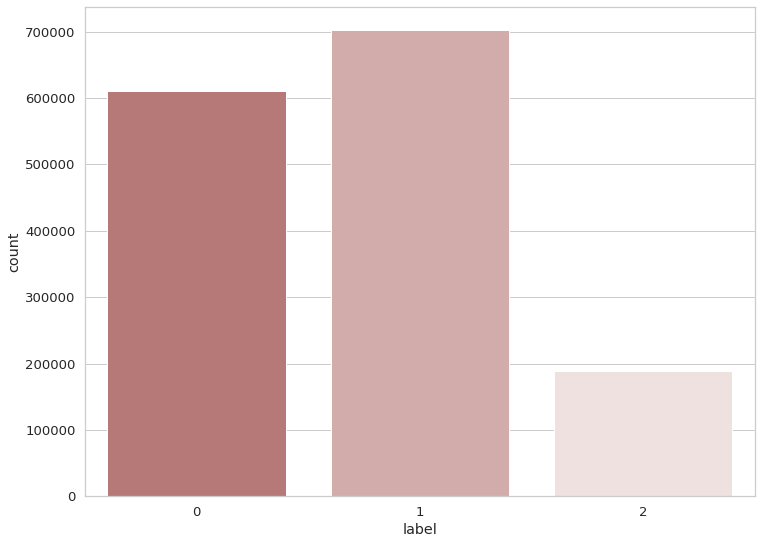

In [33]:
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 9
sns.set(style='whitegrid', palette='vlag_r', font_scale=1.2)
sns.countplot(allTweetsREV.label)

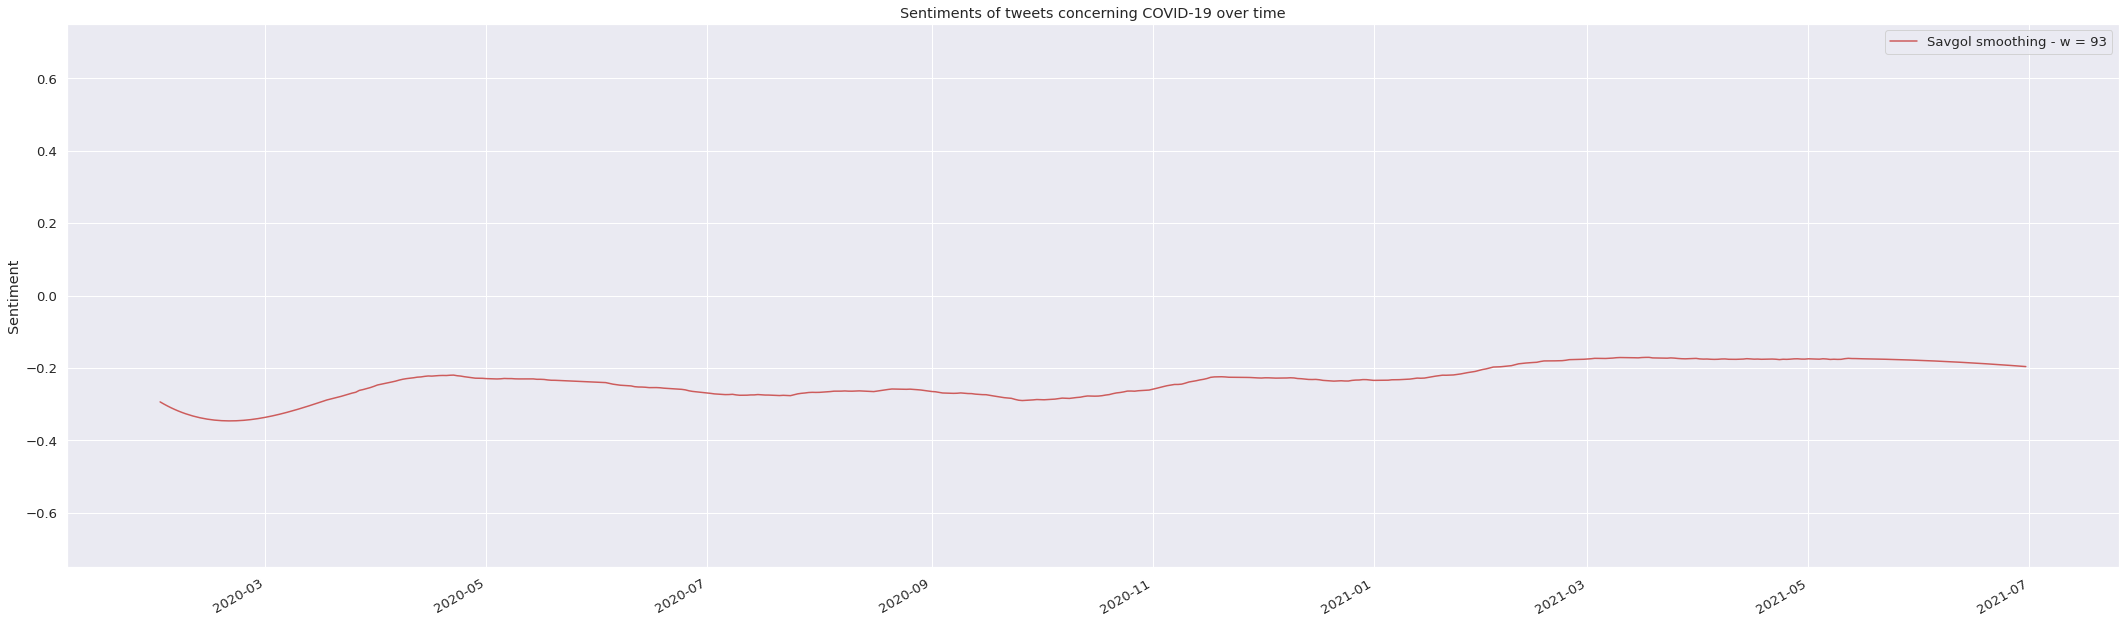

In [41]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()

from scipy.signal import savgol_filter
yhat2 = savgol_filter(allgroupedREV.score_norm, 93, 3)
ax.plot(allgroupedREV.Datetime,yhat2,color='indianred', label='Savgol smoothing - w = 93')
ax.set(title='Sentiments of tweets concerning COVID-19 over time', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()
# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

Comparison 

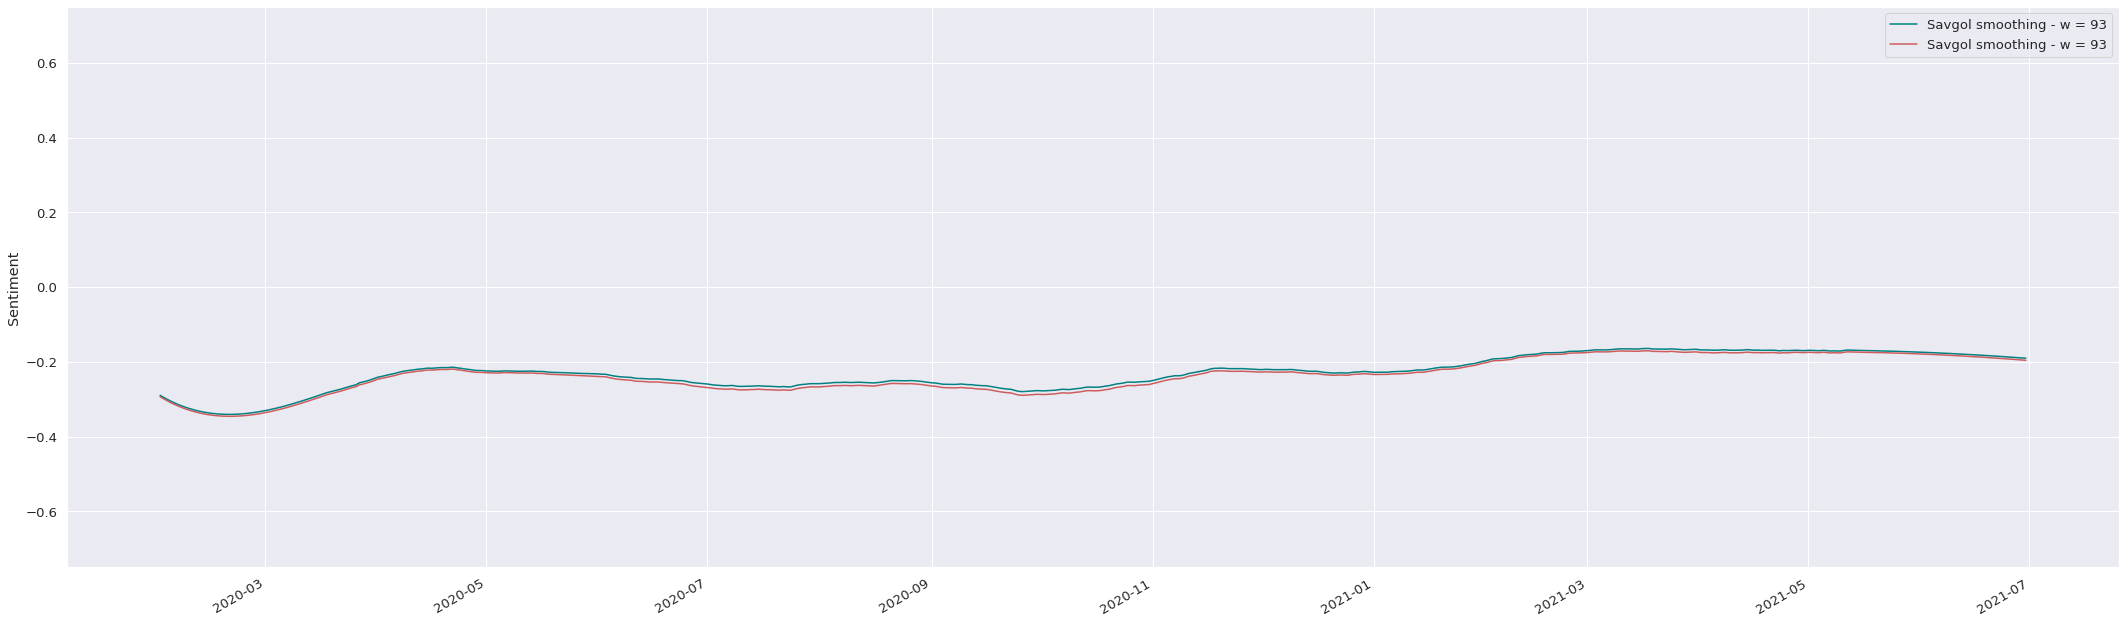

In [42]:
import seaborn as sns

sns.set_style('darkgrid')

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()

from scipy.signal import savgol_filter

yhat = savgol_filter(allgrouped.score_norm, 93, 3)
ax.plot(allgrouped.Datetime,yhat,color='teal', label='Savgol smoothing - w = 93')


yhat2 = savgol_filter(allgroupedREV.score_norm, 93, 3)
ax.plot(allgroupedREV.Datetime,yhat2,color='indianred', label='Savgol smoothing - w = 93')

ax.set( ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

# Sentiment and time series analysis on tweets concerning the vaccines
Vaccines considered:

Pfizer/BioNTech;
Sinopharm;
Sinovac;
Moderna;
Oxford/AstraZeneca;
Covaxin;
Sputnik V.

From COVID-19 AllTweets

In [ ]:

vaxfromAllTweets = allTweets[ allTweets.full_text.str.contains('Pfizer') | allTweets.full_text.str.contains('BioNTech') | allTweets.full_text.str.contains('Sputnik') | allTweets.full_text.str.contains('Covaxin') | allTweets.full_text.str.contains('AstraZeneca') | allTweets.full_text.str.contains('Sinopharm') | allTweets.full_text.str.contains('Sinovac') | allTweets.full_text.str.contains('Moderna') | allTweets.full_text.str.contains('Oxford') |
allTweets.full_text.str.contains('pfizer') | allTweets.full_text.str.contains('biontech')|allTweets.full_text.str.contains('biotech') | allTweets.full_text.str.contains('bharatbiotech')| allTweets.full_text.str.contains('sputnik')|allTweets.full_text.str.contains('sputik') | allTweets.full_text.str.contains('covaxin')| allTweets.full_text.str.contains('covax') | allTweets.full_text.str.contains('astrazeneca') | allTweets.full_text.str.contains('sinopharm') | allTweets.full_text.str.contains('sinovac') | allTweets.full_text.str.contains('moderna') | allTweets.full_text.str.contains('oxford') | allTweets.full_text.str.contains('sputnikvaccine') | allTweets.full_text.str.contains('pfizerbiontech') | allTweets.full_text.str.contains('oxfordastrazeneca') ]

In [ ]:
vaxfromAllTweets = vaxfromAllTweets[vaxfromAllTweets.index > '2020-12-01']
vaxfromAllTweets = vaxfromAllTweets[vaxfromAllTweets.index < '2021-05-01']

In [ ]:
vaxfromAllTweets

,index,full_text,label,norm01,score_norm
Datetime,,,,,
2020-12-01 00:07:15,40270,‘Absolutely remarkable’: No one who got Modern...,2,0.766328,0.766328
2020-12-01 00:14:44,96547,@Ronnie_Rusli Here is a short video about the ...,2,0.987300,0.987300
2020-12-01 00:38:49,74305,United Airlines carried Pfizer’s Covid-19 vacc...,1,0.948703,0.000000
2020-12-01 01:03:57,69623,Moderna Inc. said it would ask U.S. and Europe...,1,0.944325,0.000000
2020-12-01 01:41:04,87885,"""Moderna files for approval of COVID-19 vaccin...",1,0.893128,0.000000
...,...,...,...,...,...
2021-04-30 22:14:07,92037,Pfizer to start shipping coronavirus vaccine t...,1,0.957312,0.000000
2021-04-30 22:15:04,39026,IT’S TIME TO GET VACCINATED! This Sunday at Ot...,2,0.965838,0.965838
2021-04-30 22:30:14,31802,Next week @LCPublicHealth will begin offering ...,1,0.930682,0.000000


In [ ]:
vaxfromAllTweets[vaxfromAllTweets['label'] == 0]

,index,full_text,label,norm01,score_norm
Datetime,,,,,
2020-12-01 04:57:49,41520,@marceelias @GOP &amp; @Trump causing exponent...,0,0.961875,-0.961875
2020-12-01 06:33:22,52447,MRNA bullish throughout 2021 as the world is w...,0,0.855369,-0.855369
2020-12-01 08:50:39,2328,Globally @AstraZeneca and @pfizer halted trial...,0,0.820409,-0.820409
2020-12-01 12:42:28,8,@petedako @fordnation I hope @CanadianPM and o...,0,0.896743,-0.896743
2020-12-01 13:56:21,83964,"Sounds like an article out of @TheOnion, but t...",0,0.631310,-0.631310
...,...,...,...,...,...
2021-04-30 17:46:20,60437,@anadoluagency Can you trust a Vaccine Called ...,0,0.907363,-0.907363
2021-04-30 19:31:02,23630,Bad News: Risk from virus variants remains aft...,0,0.804135,-0.804135
2021-04-30 20:25:58,18208,@mgtkn @Reuters @Laurie_Garrett There is lots ...,0,0.511886,-0.511886


In [ ]:
print( len(vaxfromAllTweets[vaxfromAllTweets['label'] == 2]))
print( len(vaxfromAllTweets[vaxfromAllTweets['label'] == 0]))

1279
2555


In [ ]:
# vaxfromAllTweets.to_csv('/content/drive/MyDrive/NLP/COVID19data/vaxInHouse.csv', line_terminator='\n')

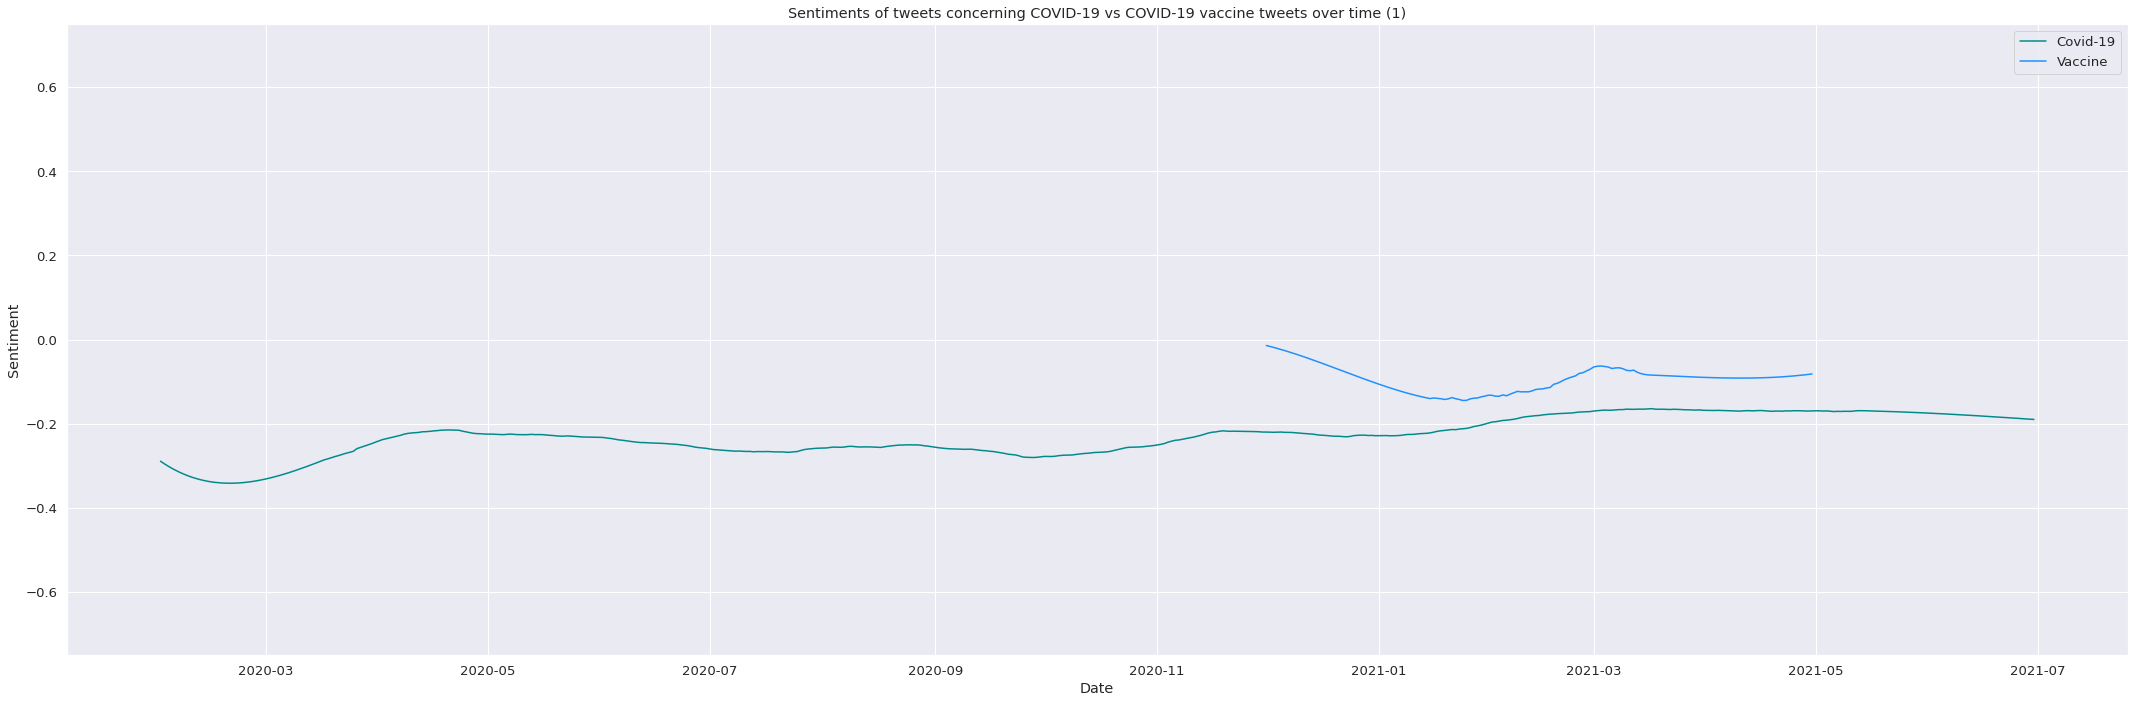

In [ ]:
# vaxfromAllTweets.set_index('Datetime')
toTimeSeriesVax1 = vaxfromAllTweets[['full_text','score_norm']]

groupedVax1 = toTimeSeriesVax1.resample('1D')

allgroupedVax1 = groupedVax1.mean().reset_index()
allgroupedVax1["score_norm"] = pd.to_numeric(allgroupedVax1["score_norm"])


fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
# ax.plot(allgrouped.Datetime,allgrouped.score_norm,color='paleturquoise', label='Mean sentiment score per day')

from scipy.signal import savgol_filter

yhat = savgol_filter(allgrouped.score_norm, 91, 3)
ax.plot(allgrouped.Datetime,yhat,color='darkcyan', label='Covid-19')

yhat2 = savgol_filter(allgroupedVax1.score_norm, 91, 3)
ax.plot(allgroupedVax1.Datetime,yhat2,color='dodgerblue', label='Vaccine')

ax.set(title='Sentiments of tweets concerning COVID-19 vs COVID-19 vaccine tweets over time (1)', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

plt.show()

From external Dataset

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


vaxTweets = pd.read_csv("/content/drive/MyDrive/NLP/COVID19data/vaxTweetstillApril.csv") 
vaxTweets['date'] = pd.to_datetime(vaxTweets['date'])
vaxTweets = vaxTweets[['date','text']].set_index('date')

from langdetect import detect


def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False


def preprocess_predictVax(df):

  df = df[df['text'].apply(is_en)]

  # Run function `preprocessing_for_bert` on the train set and the validation set
  print('Tokenizing data...')
  text_inputs, text_masks = preprocessing_for_bert(df.text)

  # For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
  batch_size = 16

  # Create the DataLoader for our test set
  test_dataset = TensorDataset(text_inputs, text_masks)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  # predictions array
  probs = bert_predict(modeLoaded, test_dataloader)

  tensorprobs = torch.from_numpy(probs)
  tensorlabels = torch.max(tensorprobs, dim=1)

  df['label'] = tensorlabels[1].cpu().numpy()
  df['norm01'] = tensorlabels[0].cpu().numpy()

  return df

vaxTweetsPredicts =  preprocess_predictVax(vaxTweets)

# del vaxTweets
clear_output()

In [ ]:
vaxTweetsPredicts

,text,label,norm01
date,,,
2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,1,0.813355
2020-12-13 16:27:13,While the world has been on the wrong side of ...,0,0.860166
2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,1,0.956222
2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",1,0.747840
2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,1,0.705984
...,...,...,...
2021-04-14 08:24:54,✅ 🇷🇺#Gamaleya Research Center in cooperation w...,1,0.960859
2021-04-14 08:16:35,@FloydShivambu #SputnikV. Where are #AfricanEx...,1,0.797099
2021-04-14 08:11:21,"Hello, it s because of this stubbornness and f...",0,0.907530


In [ ]:
vaxTweetsPredicts['text'] = vaxTweetsPredicts['text'].apply(lambda x: re.sub(r'((https?://[^\s]+)|(www\.[^\s]+))','',x)
 )
vaxTweetsPredicts['text'] = vaxTweetsPredicts['text'].apply(lambda x: re.sub(r'RT (@.*?)[\s]', '', x) )
vaxTweetsPredicts['text'] = vaxTweetsPredicts['text'].apply(lambda x: re.sub(r'\"RT ', '', x))
vaxTweetsPredicts['text'] = vaxTweetsPredicts['text'].apply(lambda x: re.sub(r'RT ', '', x) if (x.find("RT ") == 0) else x)
vaxTweetsPredicts['text'] = vaxTweetsPredicts['text'].apply(lambda x: re.sub(r'QT |\"QT ', '', x) if (x.find("QT ") == 0 or x.find("QT ") == 1 ) else x)
vaxTweetsPredicts['text'] = vaxTweetsPredicts['text'].apply(lambda x: re.sub(r'(@.*?)[\s]', '', x) if (x.find("@") == 0) else x )

vaxTweetsPredicts.drop_duplicates(keep=False,inplace=True)

In [ ]:
vaxTweetsPredictsTemp = vaxTweetsPredicts
vaxTweetsPredictsTemp['Datetime'] = pd.to_datetime(vaxTweetsPredictsTemp.index)
clear_output()

In [ ]:
print( len(vaxTweetsPredictsTemp[vaxTweetsPredictsTemp['label'] == 2]))
print( len(vaxTweetsPredictsTemp[vaxTweetsPredictsTemp['label'] == 0]))

13484
13808


In [ ]:

vaxTweetsPredictsTemp = normalizeScores(vaxTweetsPredictsTemp);

clear_output()

In [ ]:
vaxTweetsPredictsTemp = vaxTweetsPredictsTemp.set_index('Datetime')

In [ ]:

vaxTweetsPredictsTemp.columns = vaxTweetsPredictsTemp.columns.str.replace('text', 'full_text')

toTimeSeriesVax = vaxTweetsPredictsTemp[['full_text','score_norm']]

In [ ]:
groupedVax = toTimeSeriesVax.resample('1D')

allgroupedVax = groupedVax.mean().reset_index()
allgroupedVax["score_norm"] = pd.to_numeric(allgroupedVax["score_norm"])


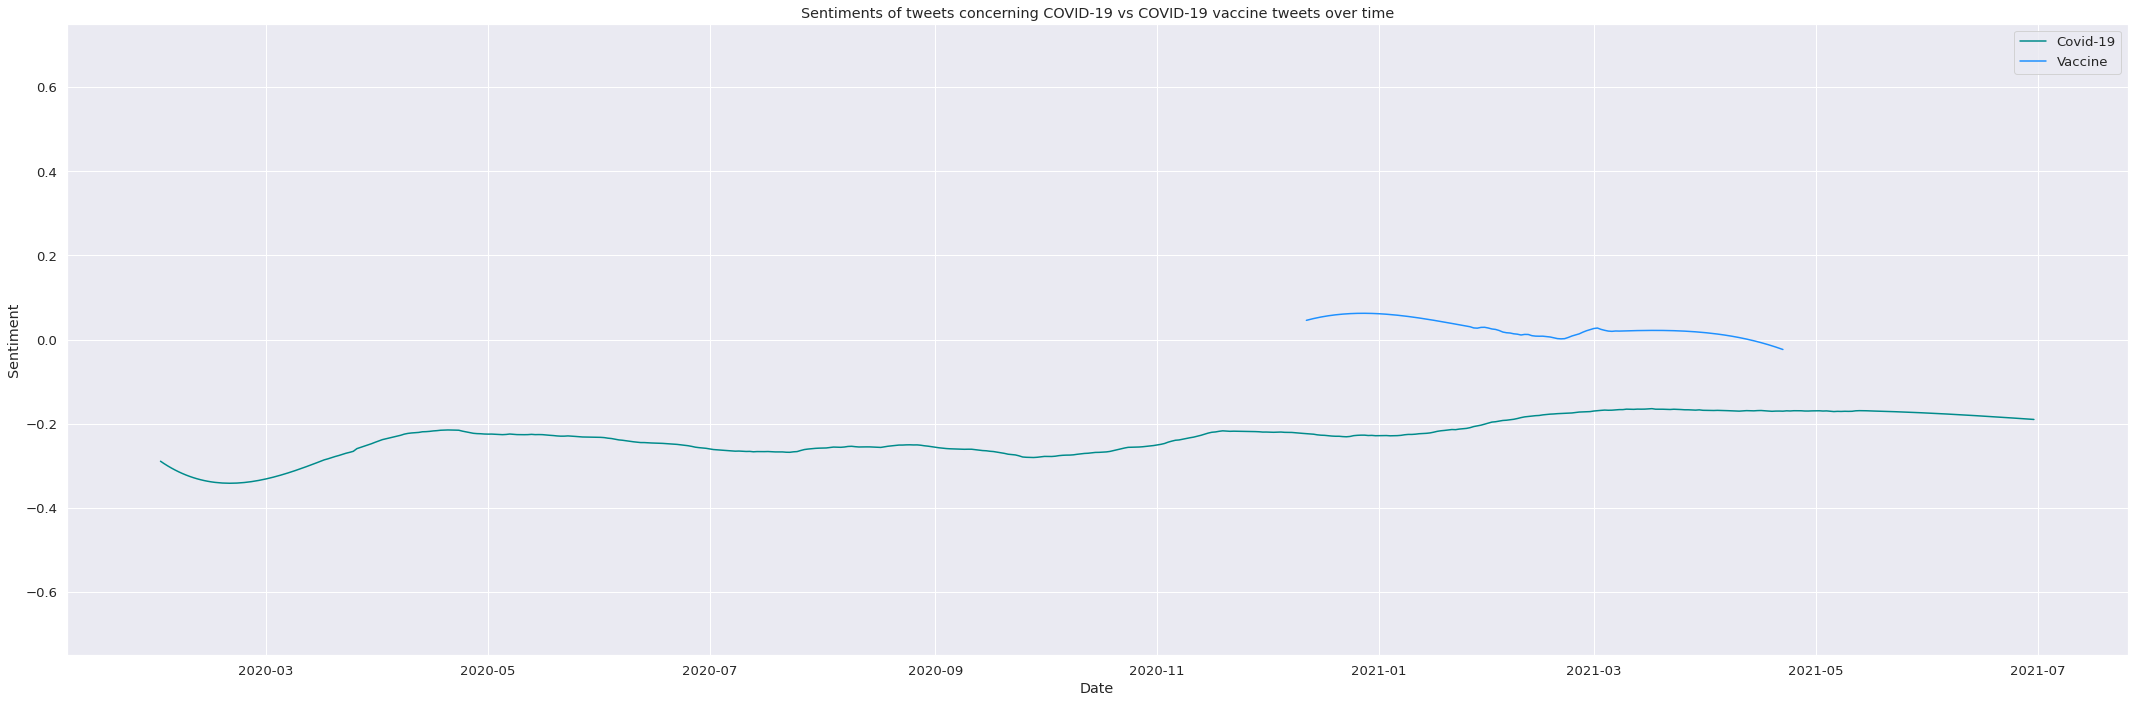

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
# ax.plot(allgrouped.Datetime,allgrouped.score_norm,color='paleturquoise', label='Mean sentiment score per day')

from scipy.signal import savgol_filter

yhat = savgol_filter(allgrouped.score_norm, 91, 3)
ax.plot(allgrouped.Datetime,yhat,color='darkcyan', label='Covid-19')

yhat2 = savgol_filter(allgroupedVax.score_norm, 91, 3)
ax.plot(allgroupedVax.Datetime,yhat2,color='dodgerblue', label='Vaccine')

ax.set(title='Sentiments of tweets concerning COVID-19 vs COVID-19 vaccine tweets over time', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

plt.show()

Appended

In [ ]:
appendedVaccineTweets = toTimeSeriesVax1.append(toTimeSeriesVax)

In [ ]:
#Remove duplicates

appendedVaccineTweets['full_text'] = appendedVaccineTweets['full_text'].apply(lambda x: re.sub(r'((https?://[^\s]+)|(www\.[^\s]+))','',x)
 )
appendedVaccineTweets['full_text'] = appendedVaccineTweets['full_text'].apply(lambda x: re.sub(r'RT (@.*?)[\s]', '', x) )
appendedVaccineTweets['full_text'] = appendedVaccineTweets['full_text'].apply(lambda x: re.sub(r'\"RT ', '', x))
appendedVaccineTweets['full_text'] = appendedVaccineTweets['full_text'].apply(lambda x: re.sub(r'RT ', '', x) if (x.find("RT ") == 0) else x)
appendedVaccineTweets['full_text'] = appendedVaccineTweets['full_text'].apply(lambda x: re.sub(r'QT |\"QT ', '', x) if (x.find("QT ") == 0 or x.find("QT ") == 1 ) else x)
appendedVaccineTweets['full_text'] = appendedVaccineTweets['full_text'].apply(lambda x: re.sub(r'(@.*?)[\s]', '', x) if (x.find("@") == 0) else x )

appendedVaccineTweets.drop_duplicates(keep=False,inplace=True)


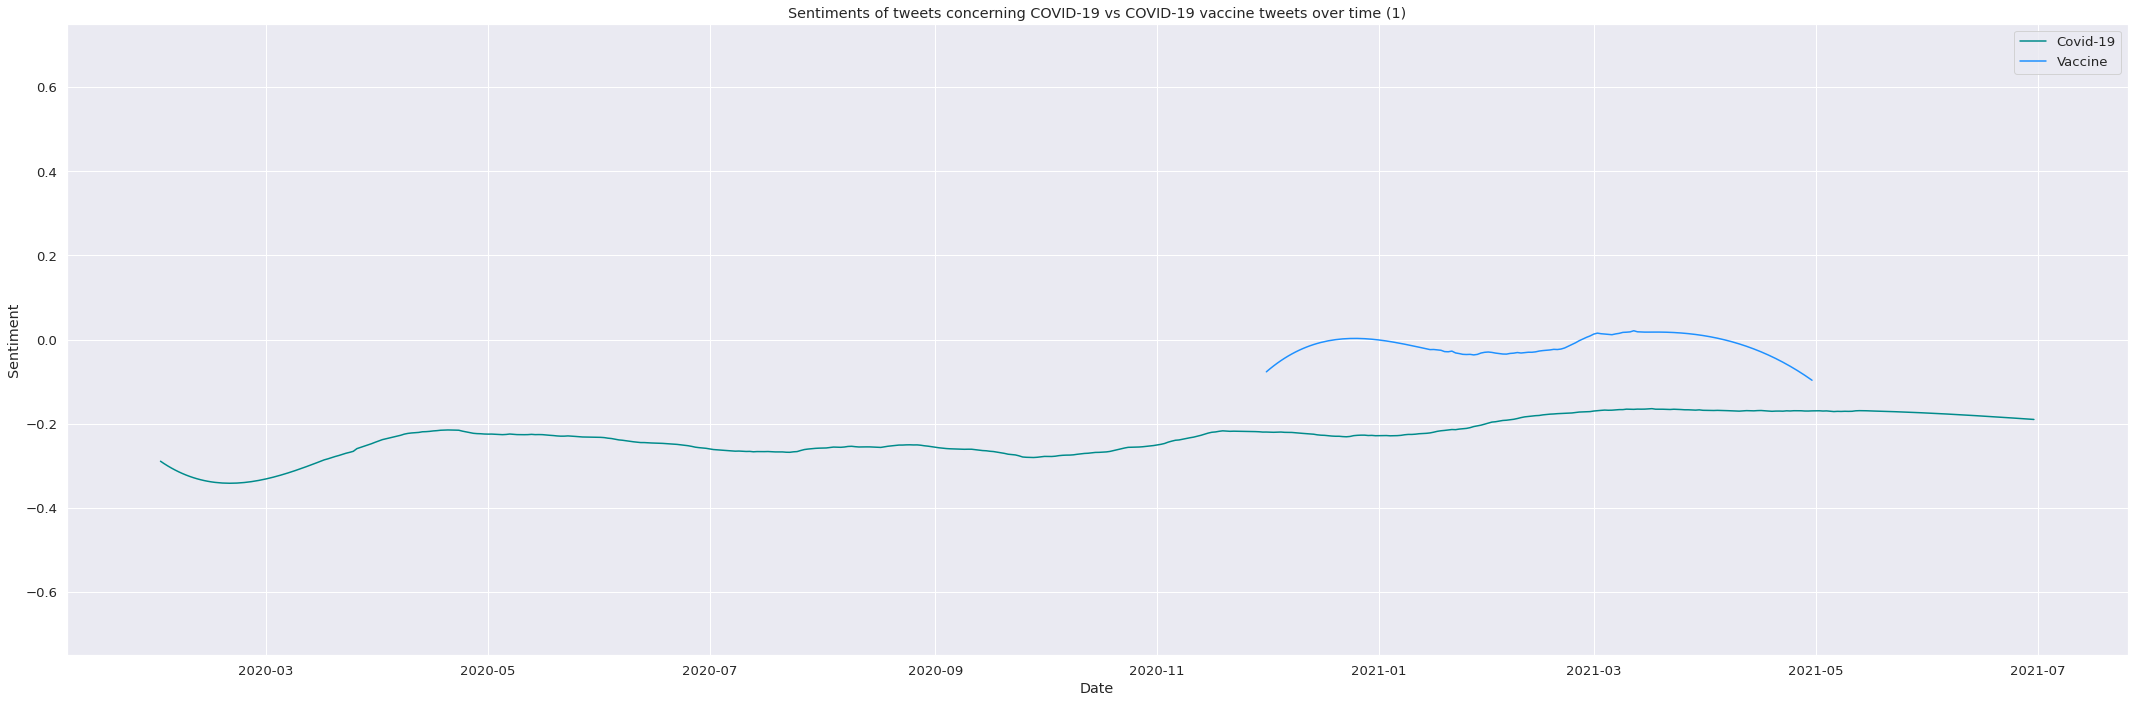

In [ ]:
# vaxfromAllTweets.set_index('Datetime')
import seaborn as sns

sns.set_style('darkgrid')
groupedVaxAppend = appendedVaccineTweets.resample('1D')

groupedVaxAppend = groupedVaxAppend.mean().reset_index()
groupedVaxAppend["score_norm"] = pd.to_numeric(groupedVaxAppend["score_norm"])


fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111)
# ax.plot(allgrouped.Datetime,allgrouped.score_norm,color='paleturquoise', label='Mean sentiment score per day')

from scipy.signal import savgol_filter

yhat = savgol_filter(allgrouped.score_norm, 91, 3)
ax.plot(allgrouped.Datetime,yhat,color='darkcyan', label='Covid-19')

yhat2 = savgol_filter(groupedVaxAppend.score_norm, 91, 3)
ax.plot(groupedVaxAppend.Datetime,yhat2,color='dodgerblue', label='Vaccine')

ax.set(title='Sentiments of tweets concerning COVID-19 vs COVID-19 vaccine tweets over time', xlabel='Date', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

plt.show()

Eaach vaccine on its own

Working on ...:  Pfizer
            score_norm
2020-12-01   -0.032472
2020-12-02    0.058941
2020-12-03   -0.066730
2020-12-04   -0.179611
2020-12-05    0.126964
...                ...
2021-04-26   -0.152769
2021-04-27    0.007945
2021-04-28    0.041656
2021-04-29   -0.235196
2021-04-30   -0.017898

[151 rows x 1 columns]


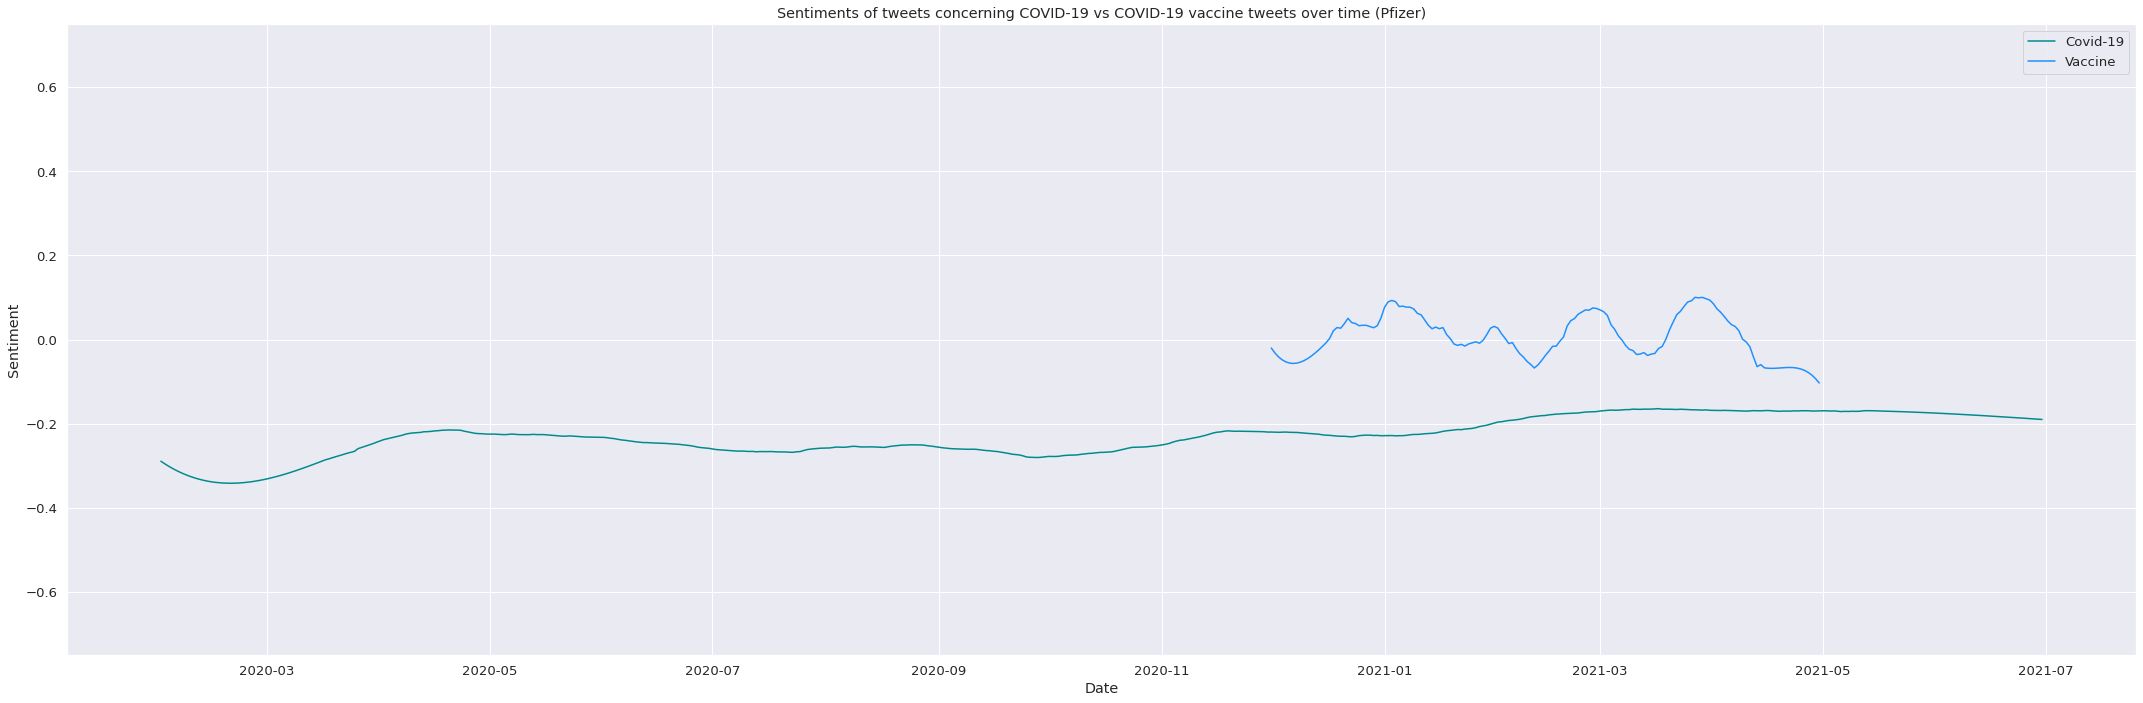

Working on ...:  Sinopharm
            score_norm
2020-12-04    0.000000
2020-12-05         NaN
2020-12-06         NaN
2020-12-07         NaN
2020-12-08         NaN
...                ...
2021-04-26         NaN
2021-04-27   -0.305672
2021-04-28         NaN
2021-04-29    0.000000
2021-04-30   -0.085028

[148 rows x 1 columns]


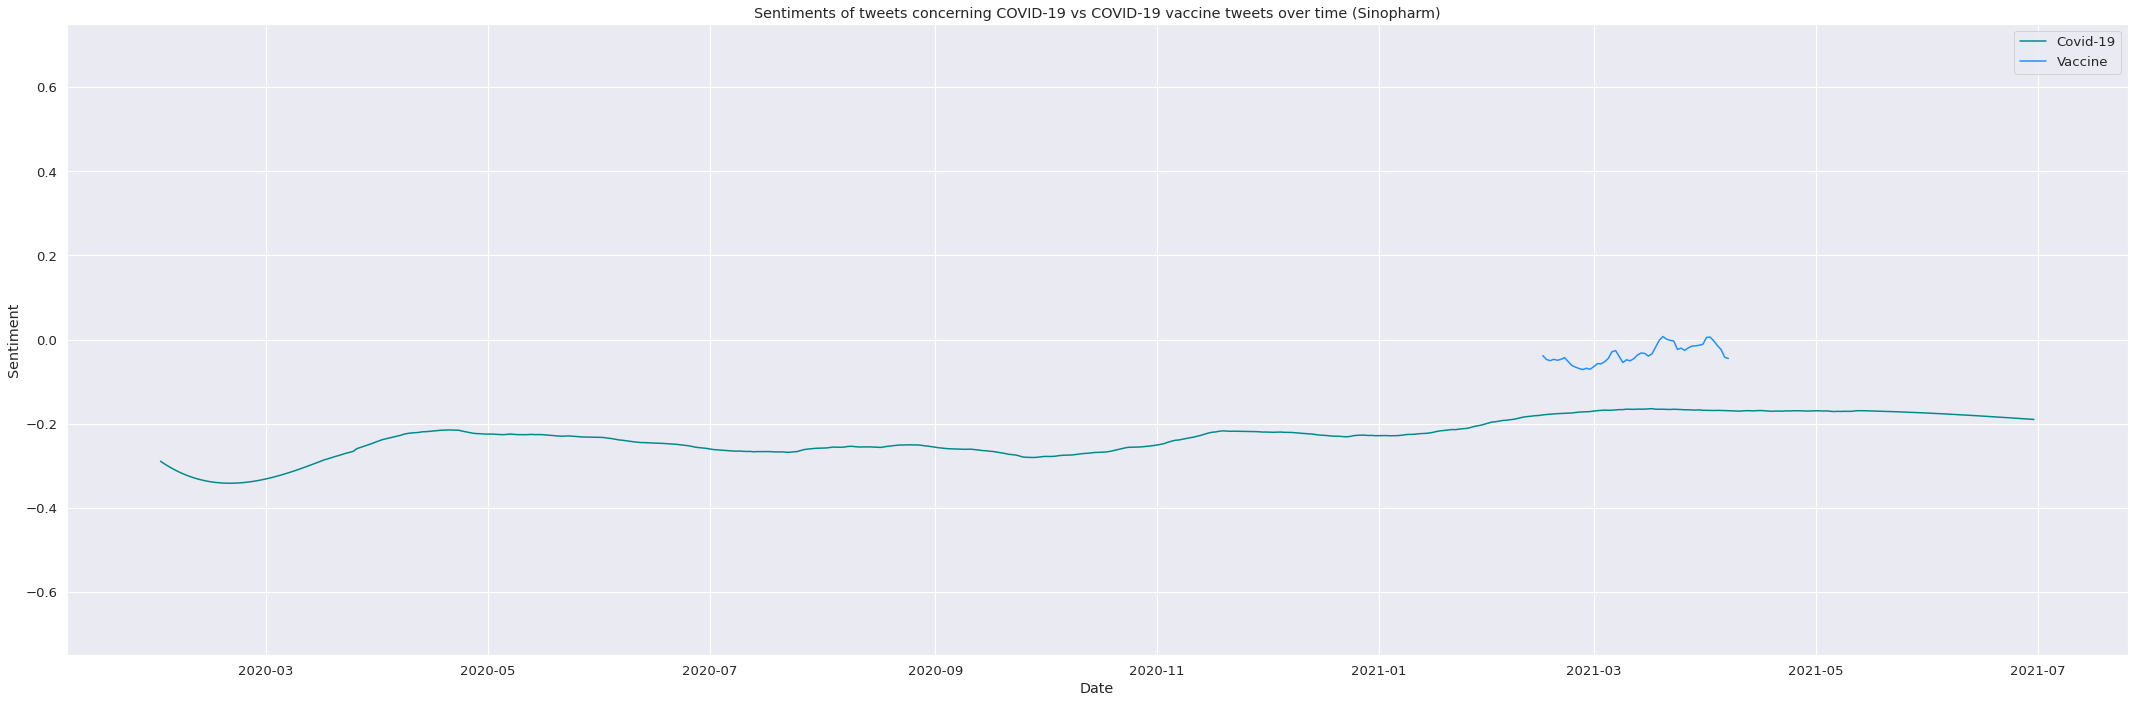

Working on ...:  Sinovac
            score_norm
2020-12-06    0.000000
2020-12-07    0.152138
2020-12-08    0.000000
2020-12-09    0.000000
2020-12-10    0.000000
...                ...
2021-04-24   -0.409835
2021-04-25         NaN
2021-04-26    0.000000
2021-04-27         NaN
2021-04-28    0.000000

[144 rows x 1 columns]


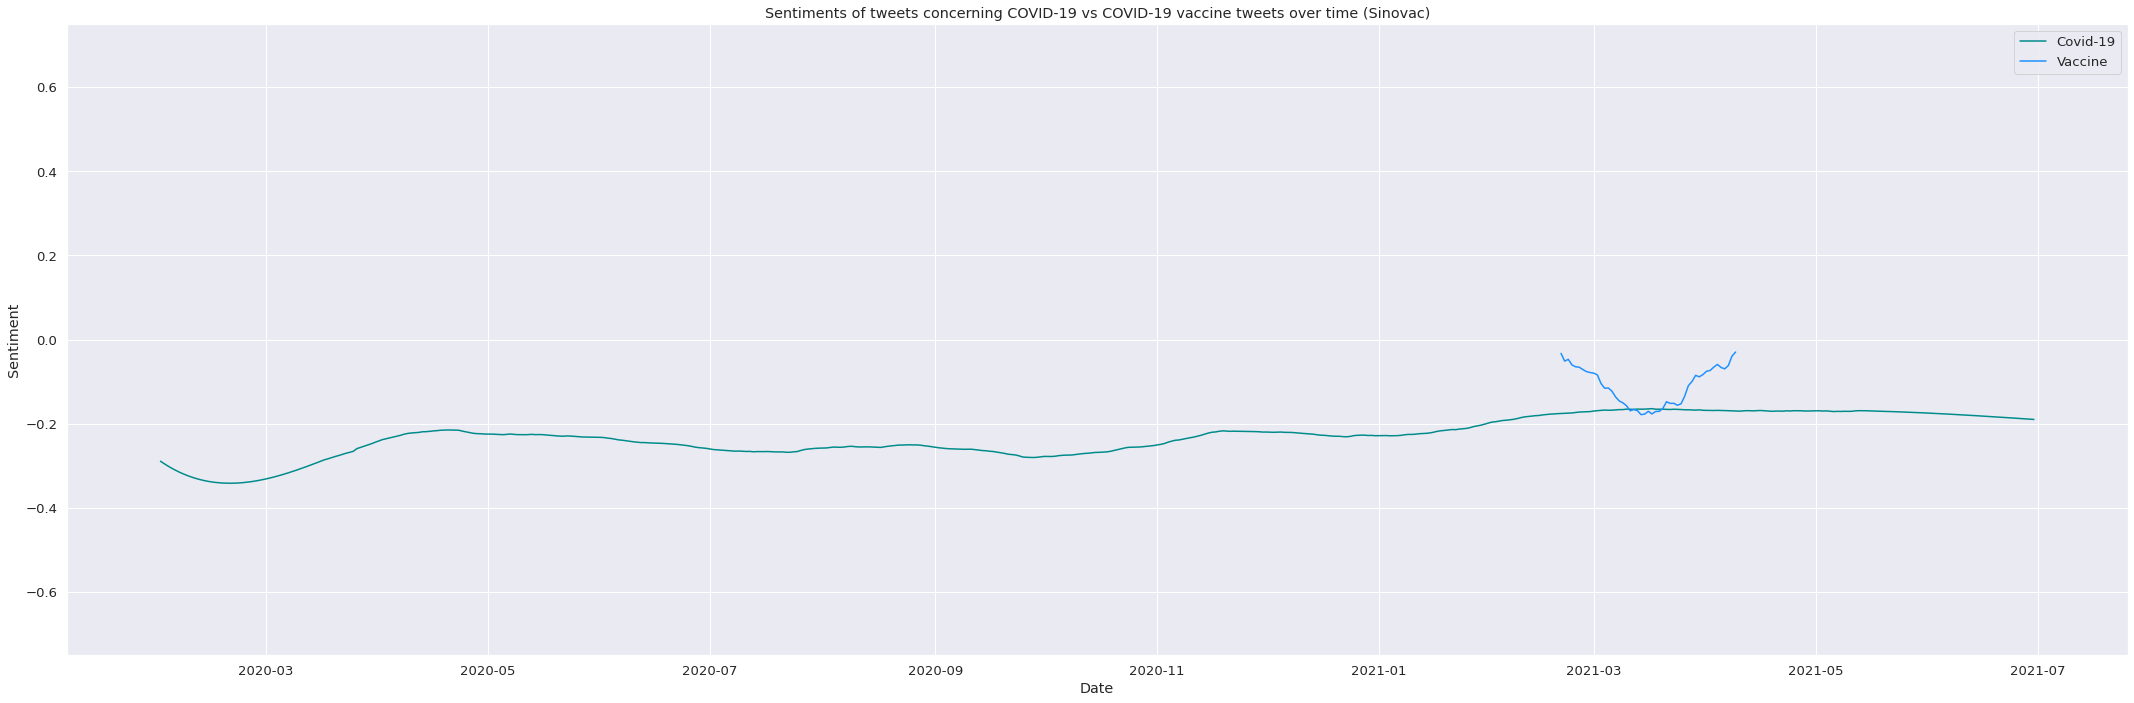

Working on ...:  Moderna
            score_norm
2020-12-01   -0.006392
2020-12-02   -0.068115
2020-12-03    0.061784
2020-12-04    0.000000
2020-12-05    0.085712
...                ...
2021-04-26   -0.225291
2021-04-27    0.102670
2021-04-28   -0.025275
2021-04-29    0.025930
2021-04-30    0.079885

[151 rows x 1 columns]


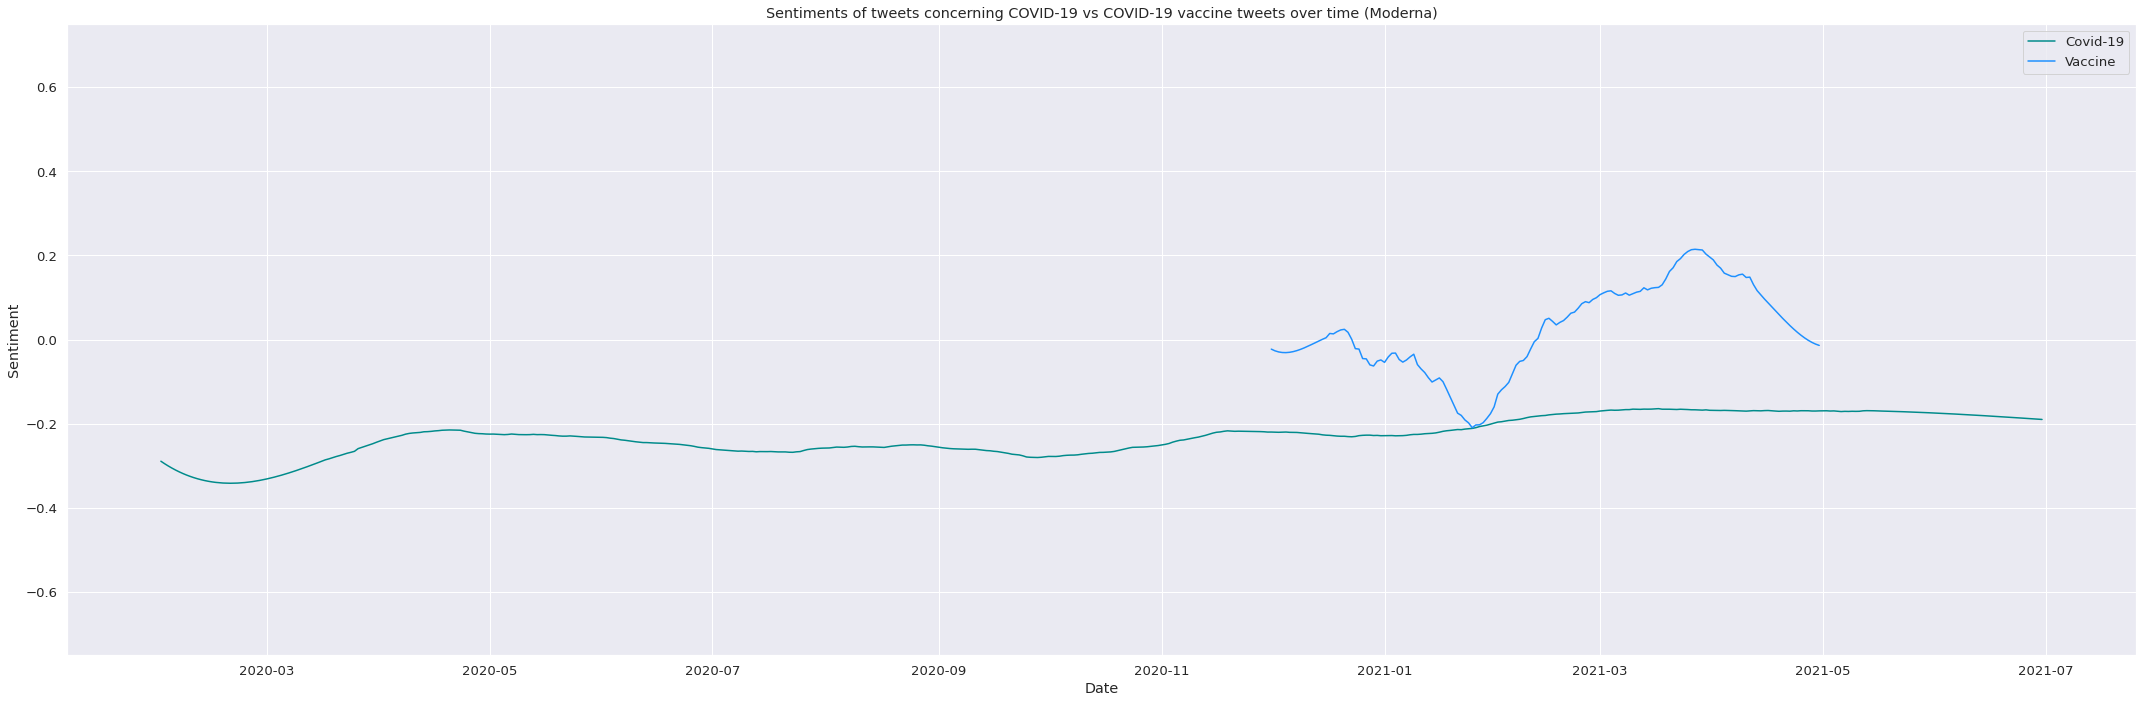

Working on ...:  Oxford
            score_norm
2020-12-01   -0.416606
2020-12-02   -0.179678
2020-12-03   -0.238519
2020-12-04    0.000000
2020-12-05    0.000000
...                ...
2021-04-26   -0.236941
2021-04-27   -0.141675
2021-04-28    0.015214
2021-04-29   -0.261842
2021-04-30    0.109976

[151 rows x 1 columns]


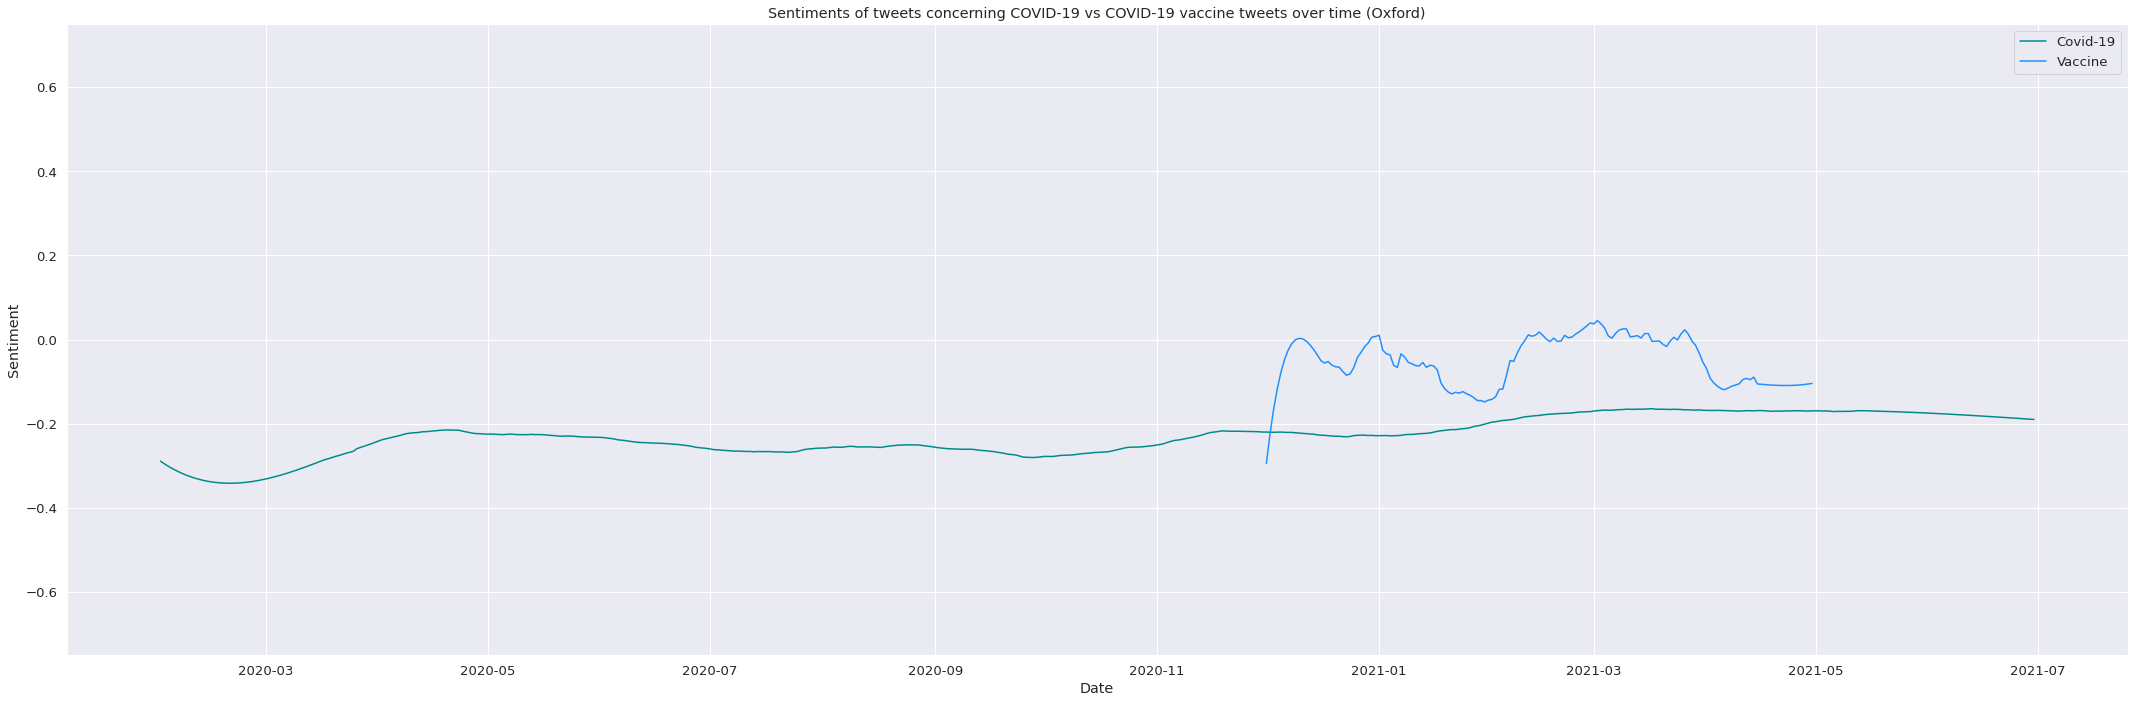

Working on ...:  Covaxin
            score_norm
2020-12-02    0.000000
2020-12-03         NaN
2020-12-04         NaN
2020-12-05    0.000000
2020-12-06    0.000000
...                ...
2021-04-26   -0.442249
2021-04-27   -0.090909
2021-04-28    0.165927
2021-04-29   -0.107979
2021-04-30   -0.101054

[150 rows x 1 columns]


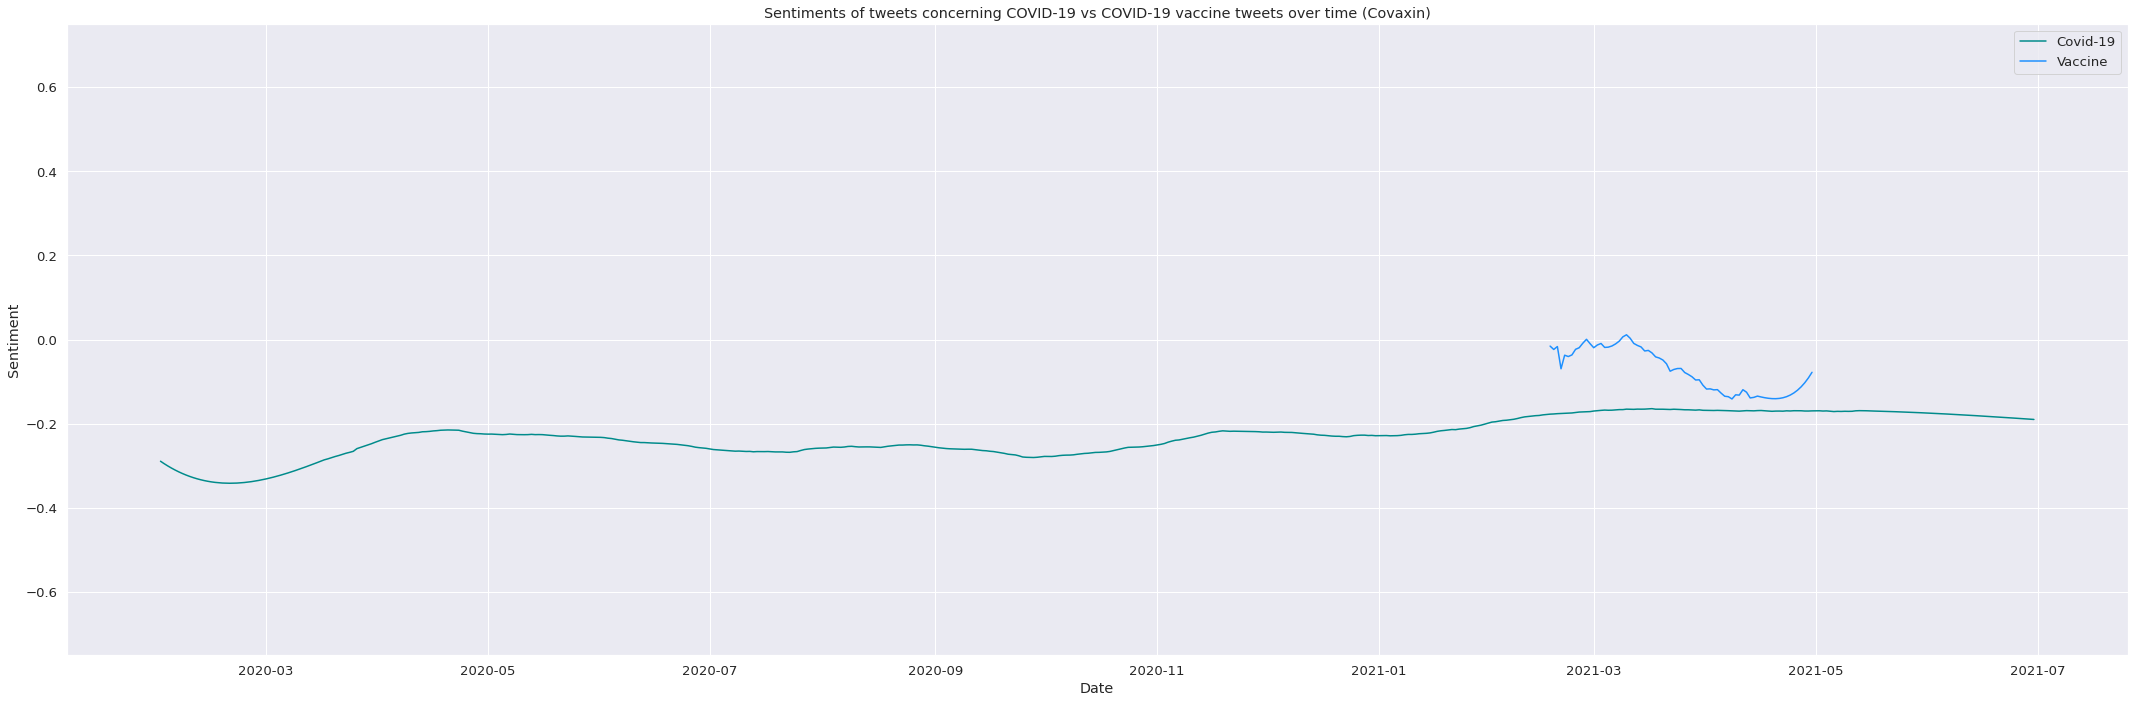

Working on ...:  Sputnik
            score_norm
2020-12-01    0.000000
2020-12-02    0.000000
2020-12-03    0.058356
2020-12-04    0.000000
2020-12-05    0.000000
...                ...
2021-04-26    0.000000
2021-04-27    0.064243
2021-04-28   -0.054986
2021-04-29   -0.145312
2021-04-30   -0.316227

[151 rows x 1 columns]


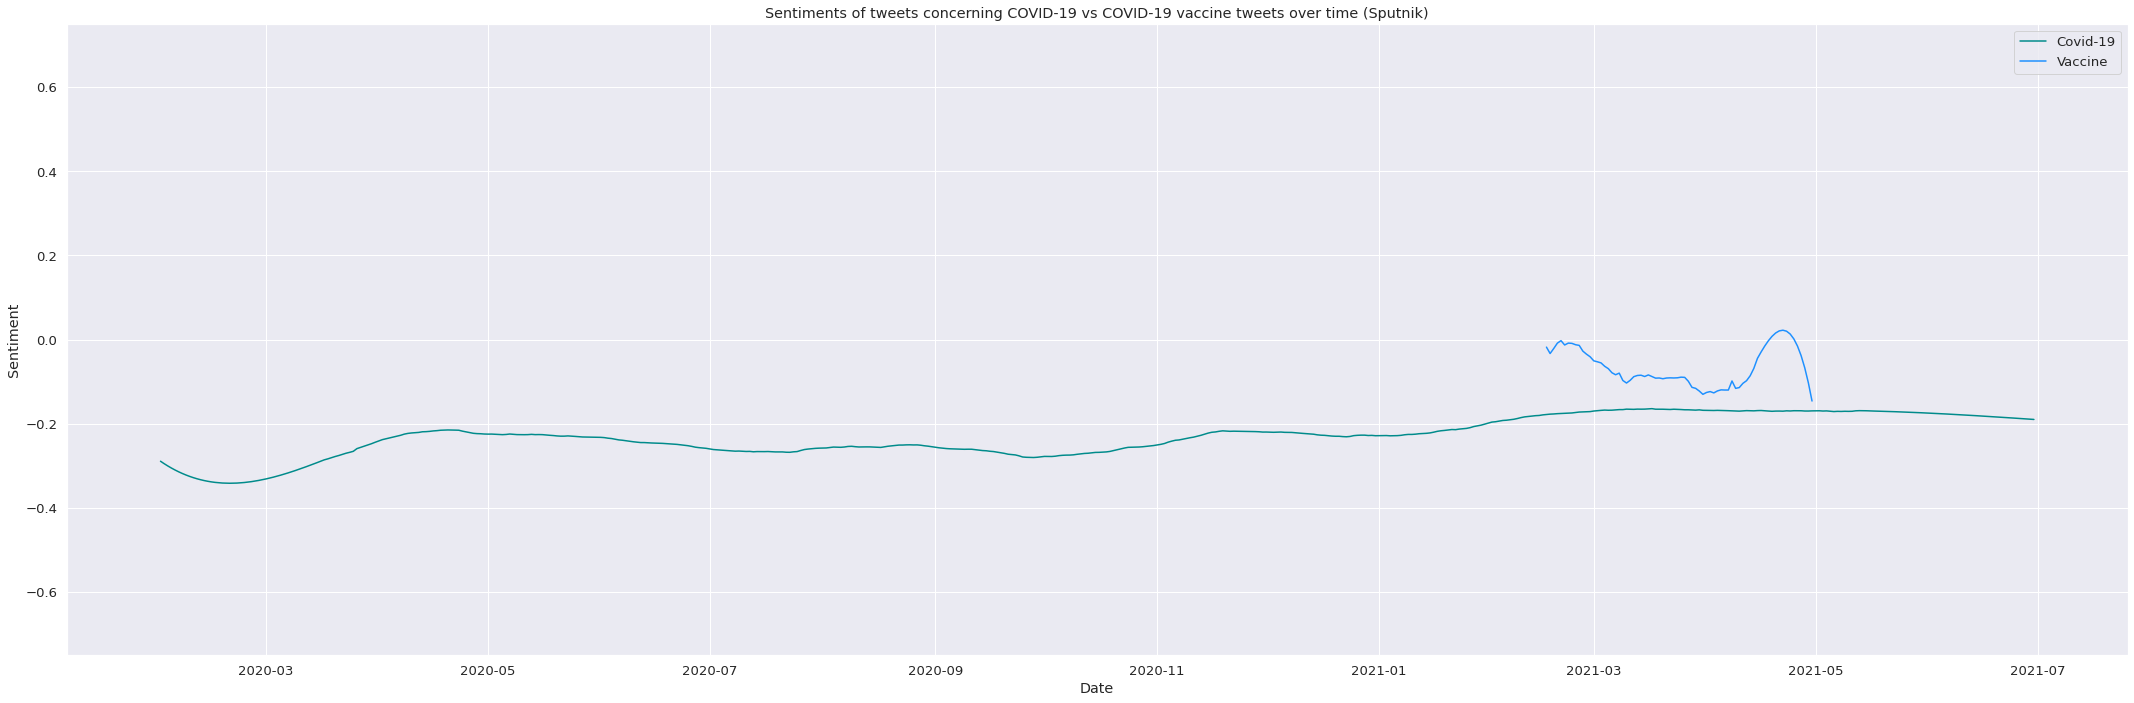

In [ ]:
keywords = [ ["Pfizer","BioNTech","pfizer",'biontech'], ["Sinopharm","sinopharm"],["Sinovac",'sinovac'],["Moderna","mrna","moderna"],["Oxford","AstraZeneca","astrazeneca","oxford"],["Covaxin","covax","covaxin"],["Sputnik","sputnik","sputnikv","sputik"]] 

from scipy.signal import savgol_filter
import seaborn as sns
sns.set_style('darkgrid')

for lis in keywords:
  temp_data = pd.DataFrame(columns=['full_text', 'score_norm'])
  print("Working on ...: " , lis[0] )
  
  for key in lis:
    temp_data = temp_data.append(appendedVaccineTweets[ appendedVaccineTweets.full_text.str.contains(key)])
 
  # temp_data = temp_data.reset_index()
  grouped_Vax = temp_data.resample('1D')
  grouped_Vax = grouped_Vax.mean()
  print(grouped_Vax)
  grouped_Vax["score_norm"] = pd.to_numeric(grouped_Vax["score_norm"])

  fig = plt.figure(figsize=(30,10))
  ax = fig.add_subplot(111)


  yhat = savgol_filter(allgrouped.score_norm, 91, 3)
  ax.plot(allgrouped.Datetime,yhat,color='darkcyan', label='Covid-19')

  yhat2 = savgol_filter(grouped_Vax.score_norm, 31, 3)
  ax.plot(grouped_Vax.index,yhat2,color='dodgerblue', label='Vaccine')

  ax.set(title='Sentiments of tweets concerning COVID-19 vs COVID-19 vaccine tweets over time ('+lis[0]+')', xlabel='Date', ylabel='Sentiment')
  ax.legend(loc='best')
  fig.tight_layout()
  plt.ylim([-0.75,0.75])
  plt.grid(True)

  plt.show()



# Death Rates

In [47]:
whoStats = pd.read_csv("/content/drive/MyDrive/NLP/COVID19data/WHO-COVID-19-global-data-sorted.csv",encoding='latin-1') 
whoStats


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,03/01/2020,AF,Afghanistan,EMRO,0,0,0,0
1,03/01/2020,AL,Albania,EURO,0,0,0,0
2,03/01/2020,DZ,Algeria,AFRO,0,0,0,0
3,03/01/2020,AS,American Samoa,WPRO,0,0,0,0
4,03/01/2020,AD,Andorra,EURO,0,0,0,0
...,...,...,...,...,...,...,...,...
202630,06/05/2022,VN,Viet Nam,WPRO,4305,10666751,2,43049
202631,06/05/2022,WF,Wallis and Futuna,WPRO,0,454,0,7
202632,06/05/2022,YE,Yemen,EMRO,0,11819,0,2149
202633,06/05/2022,ZM,Zambia,AFRO,0,319755,0,3976


In [48]:
whoStats['Date_reported'] = pd.to_datetime(whoStats['Date_reported'],format="%d/%m/%Y")
whoStats = whoStats.groupby('Date_reported').sum().sort_values(["Date_reported"], ascending=True)

end = np.where(whoStats.index == '2021-07-01')[0][0]
start = np.where(whoStats.index == '2020-02-01')[0][0]
whoStatsRange = whoStats.iloc[start:end]
whoStatsRange = whoStatsRange[[ 'New_cases',	'New_deaths',]]

In [49]:
whoStatsRangeGrouped =  whoStatsRange.resample('2D').sum()
whoStatsRangeGrouped

,New_cases,New_deaths
Date_reported,,
2020-02-01,4718,149
2020-02-03,6091,130
2020-02-05,7674,142
2020-02-07,6605,172
2020-02-09,5727,207
...,...,...
2021-06-21,656024,14932
2021-06-23,739901,15790
2021-06-25,839906,17091


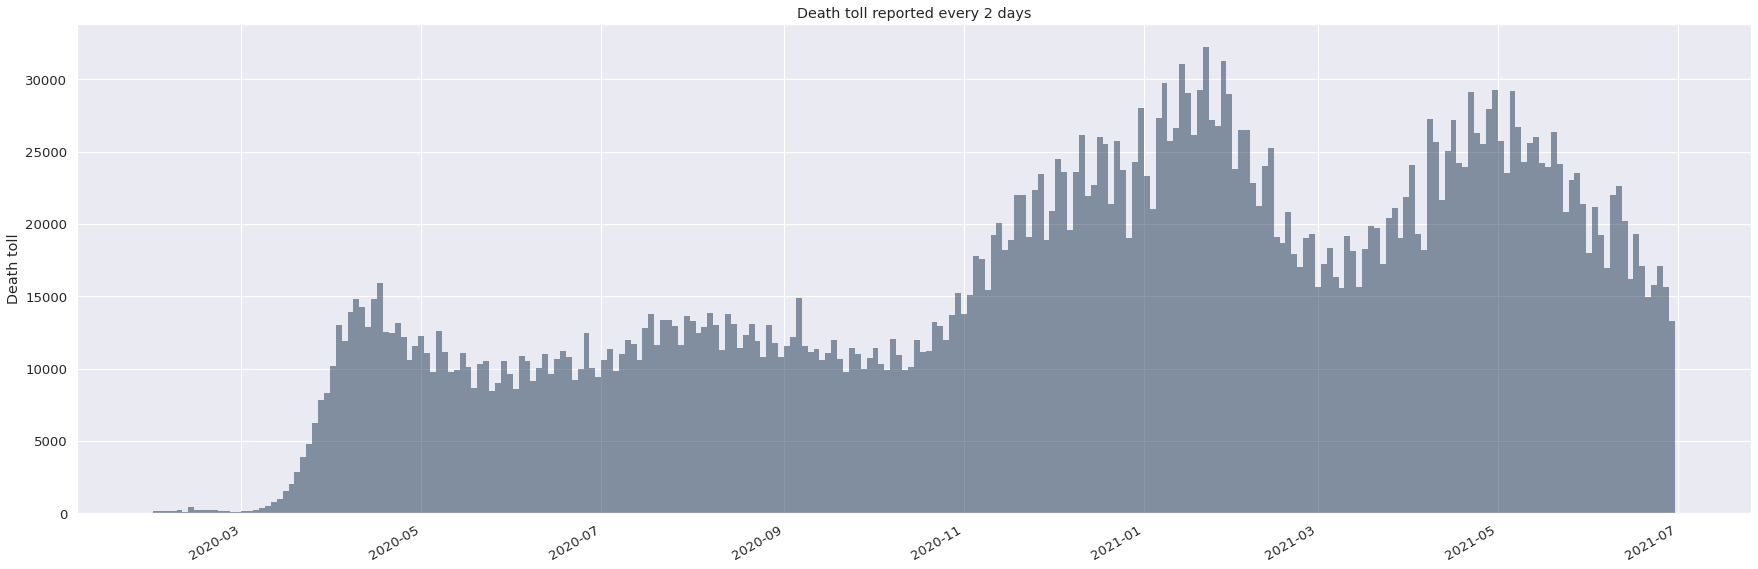

In [50]:
import seaborn as sns

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(30,10))
width = np.diff(whoStatsRangeGrouped.index).min()
ax.bar(whoStatsRangeGrouped.index, whoStatsRangeGrouped.New_deaths, alpha=0.5,color=(0.1,0.2,0.3),width=width, linewidth=0)
ax.set(title='Death toll reported every 2 days', ylabel='Death toll')

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()
# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()


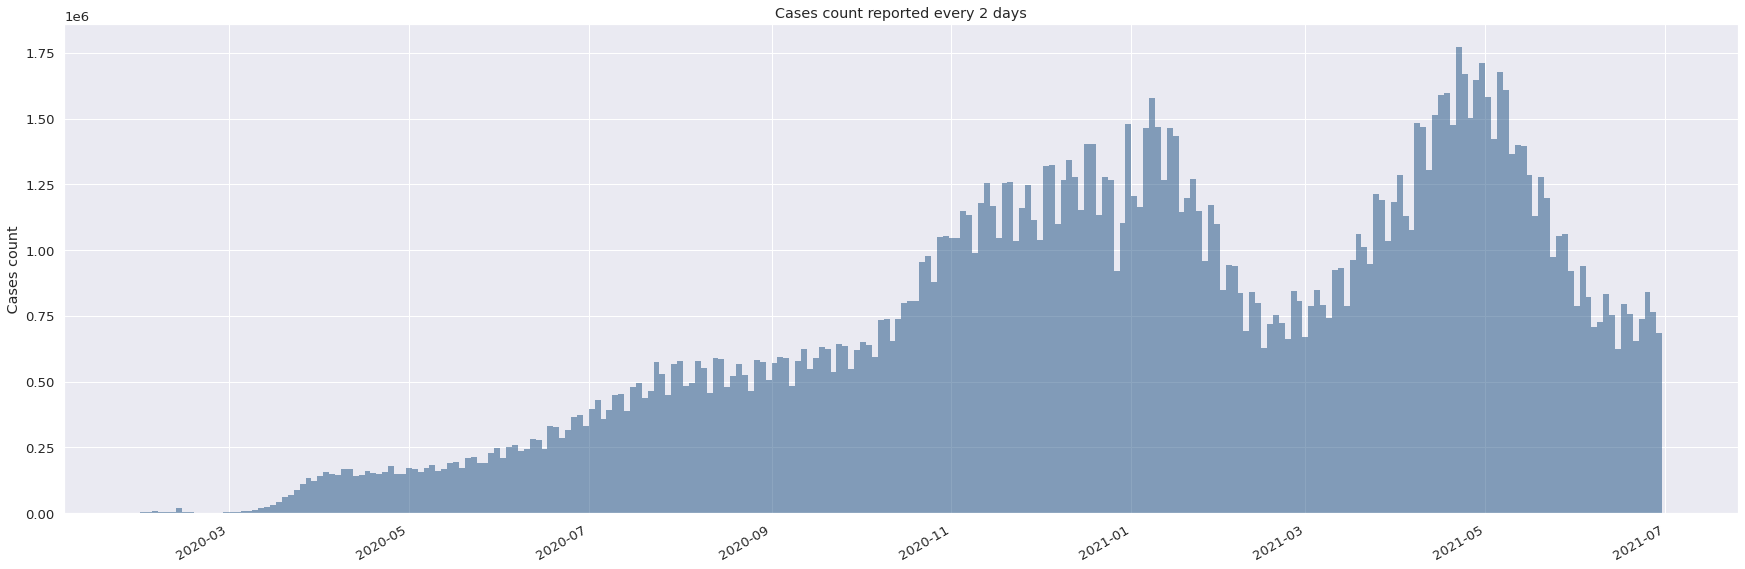

In [51]:
import seaborn as sns
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(30,10))
width = np.diff(whoStatsRangeGrouped.index).min()
ax.bar(whoStatsRangeGrouped.index, whoStatsRangeGrouped.New_cases, alpha=0.5,color=(0.1,0.3,0.5),width=width, linewidth=0)
# ax.bar(whoStatsRangeGrouped.index, whoStatsRangeGrouped.New_deaths, alpha=0.5,color=(0.2,0.2,0.4),width=width)
ax.set(title='Cases count reported every 2 days', ylabel=' Cases count ')

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()
# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()


In [52]:
import numpy as np
import scipy.stats
whoStatsCorr =  whoStatsRange.resample('1D').sum()

print(scipy.stats.pearsonr(allgrouped.score_norm, whoStatsCorr.New_deaths))

(0.6520266034776043, 8.680855266355395e-64)


In [53]:
def scaleData(x,a,b):
  scaled = (b-a) * ((x-np.min(x))/(np.max(x)-np.min(x))) + a #range
  return scaled

In [54]:
whoStatsCorr['normalizedDeaths'] = scaleData(whoStatsCorr.New_deaths,0,0.75)

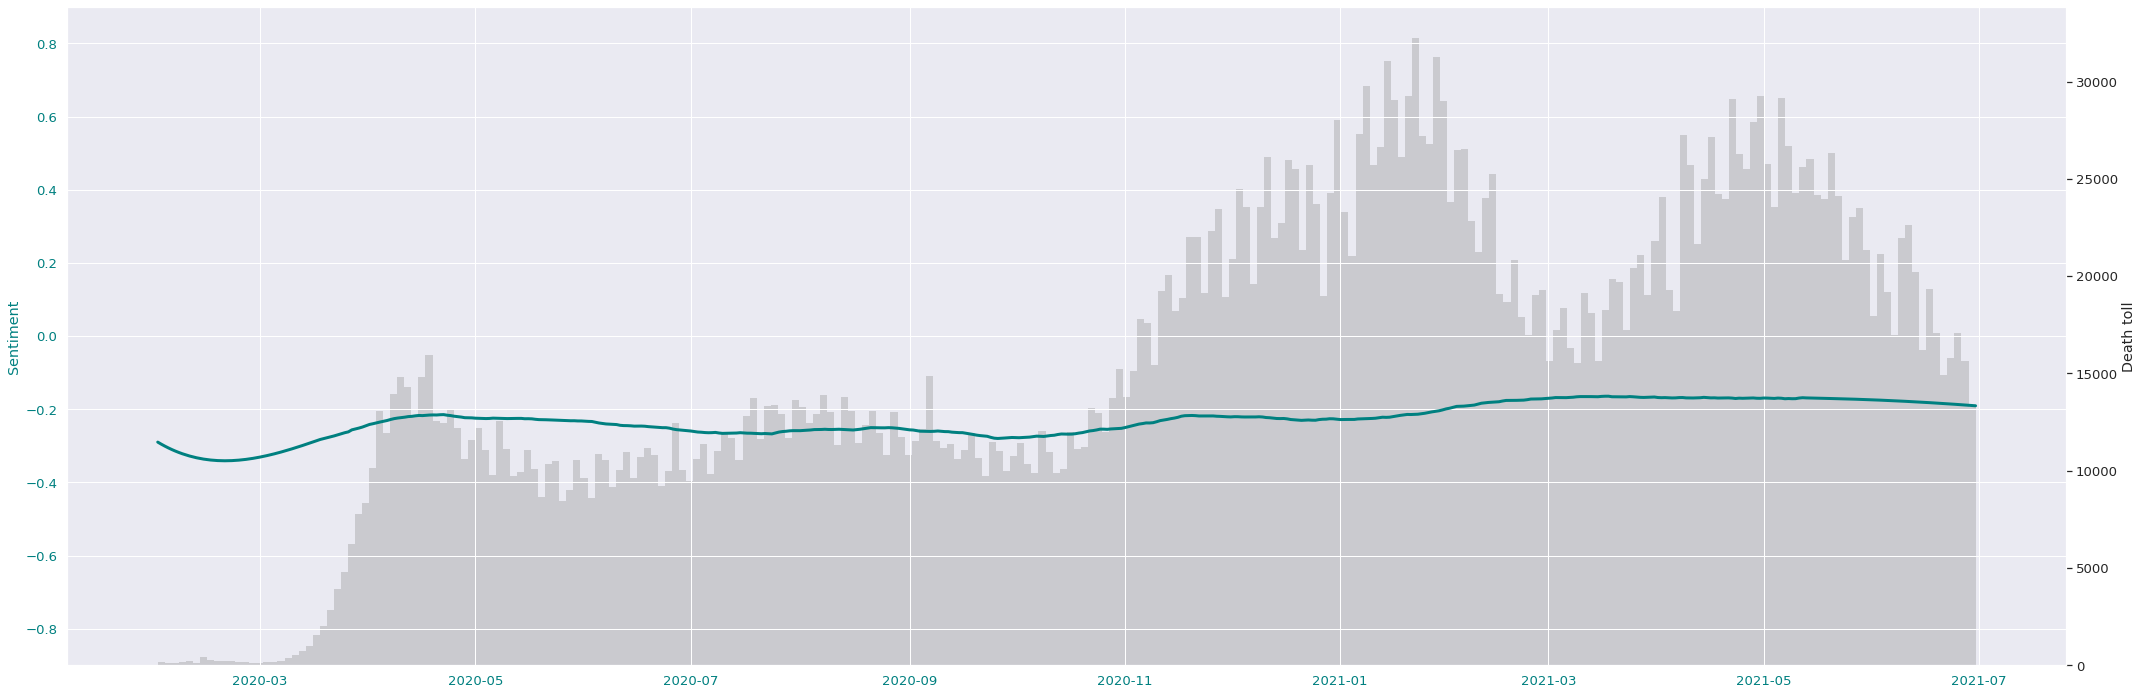

In [55]:
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
fig = plt.figure(figsize=(30,10))

ax3=fig.add_subplot(111, label="3")
ax=fig.add_subplot(111, label="1",frame_on=False)

from scipy.signal import savgol_filter
yhat = savgol_filter(allgrouped.score_norm, 93, 3)
ax.plot(allgrouped.Datetime,yhat,color='teal',linewidth=3.0 ,label='Sentiment of COVID-19 tweets')
ax.set_xlabel("", color='teal')
ax.set_ylabel("Sentiment", color='teal')
ax.tick_params(axis='x', colors='teal')
ax.tick_params(axis='y', colors='teal')
ax.set_ylim([-0.9,0.9])

width = np.diff(whoStatsRangeGrouped.index).min()
ax3.bar(whoStatsRangeGrouped.index, whoStatsRangeGrouped.New_deaths,color='grey',alpha=0.3,width=width,linewidth = 0)
ax3.set(ylabel='Death toll')
ax3.set_xticks([])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax3.grid(False)

fig.tight_layout()
plt.show()

#Hedonometer


Initially the months were divided into sets and the hedonometer scores were applied on each set and saved separately. Thus the loading of multiple files, and then appending.

In [ ]:
hedonometer_results1 = pd.read_csv('/content/drive/MyDrive/NLP/COVID19data/hedonometer_results_020320.csv')
hedonometer_results1 = hedonometer_results1[26:]
hedonometer_results2 = pd.read_csv('/content/drive/MyDrive/NLP/COVID19data/hedonometer_results_040520.csv')
hedonometer_results3 = pd.read_csv('/content/drive/MyDrive/NLP/COVID19data/hedonometer_results_111220.csv')
hedonometer_results4 = pd.read_csv('/content/drive/MyDrive/NLP/COVID19data/hedonometer_results_01020321.csv')
hedonometer_results5 = pd.read_csv('/content/drive/MyDrive/NLP/COVID19data/hedonometer_results_04050621.csv')
hedonometer_results6 = pd.read_csv('/content/drive/MyDrive/NLP/COVID19data/hedonometer_results_060708091021.csv')


In [ ]:
appended1 = hedonometer_results1.append(hedonometer_results2,ignore_index = True).append(hedonometer_results6,ignore_index = True)
appended1 = appended1.loc[:,~appended1.columns.str.match("Unnamed")]
appended1['date'] = pd.to_datetime(appended1['date'],format="%Y-%m-%d")
appended1= appended1.set_index('date')
appended2 = hedonometer_results3.append(hedonometer_results4,ignore_index = True).append(hedonometer_results5,ignore_index = True)
appended2 = appended2.loc[:,~appended2.columns.str.match("Unnamed")]
appended2['date'] = pd.to_datetime(appended2['date'],format="%Y-%m-%d")
appended2= appended2.set_index('date')

total = appended1.append(appended2)

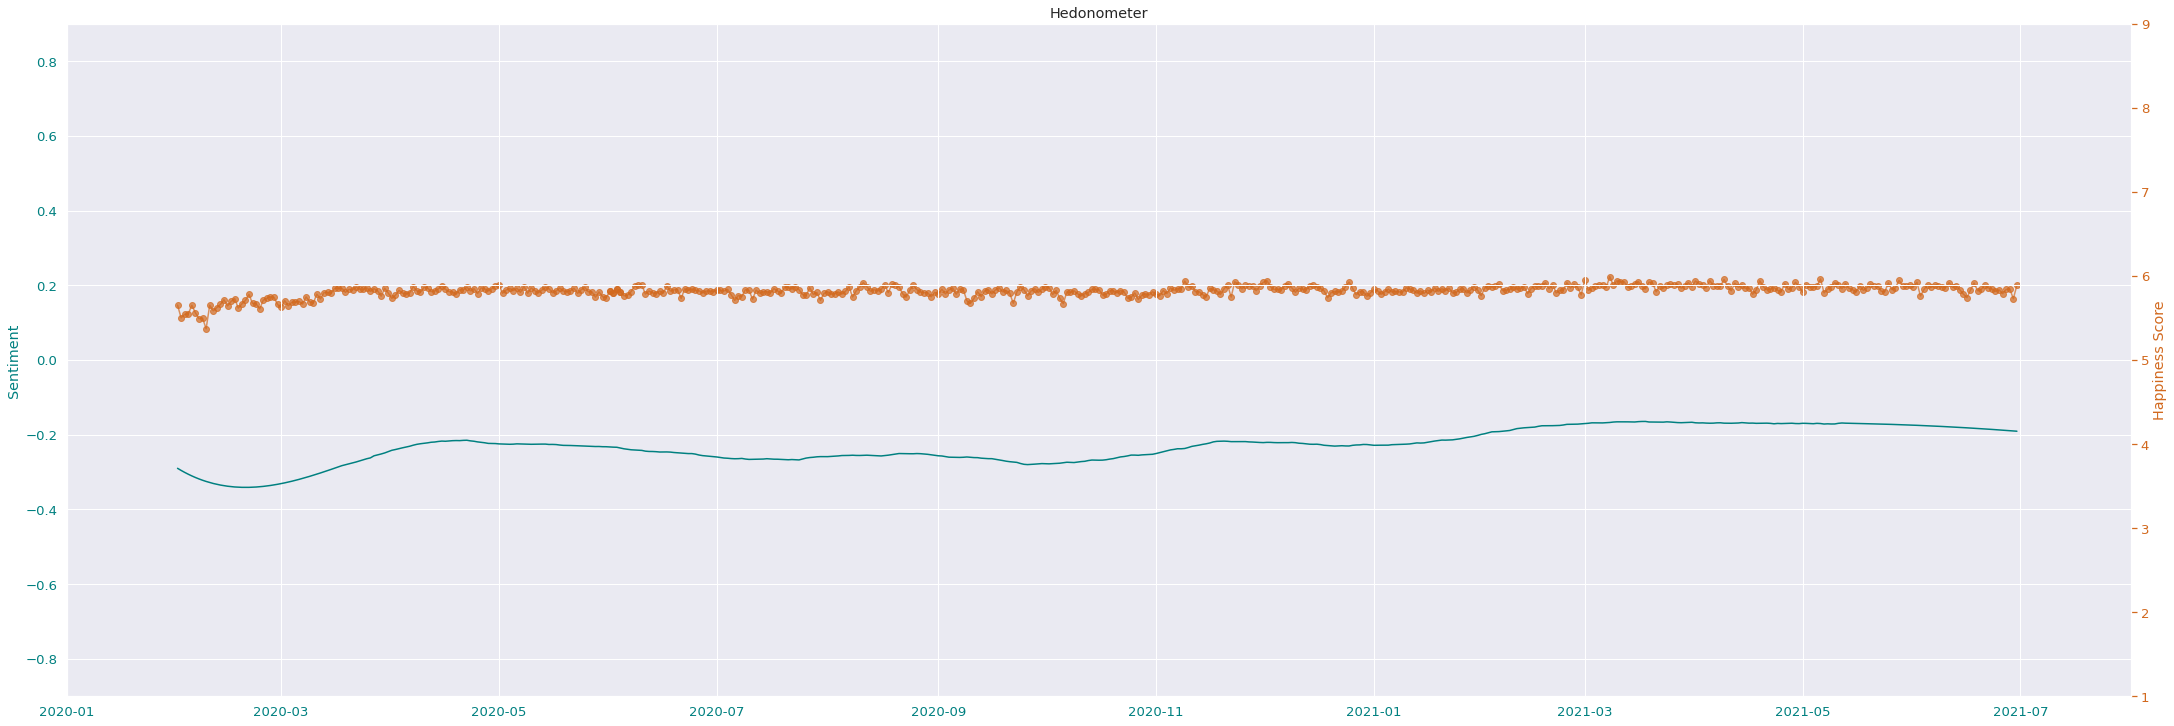

In [ ]:

import matplotlib.pyplot as plt
import datetime

sns.set_style('darkgrid')
fig = plt.figure(figsize=(30,10))

ax3=fig.add_subplot(111, label="3")
# ax2=fig.add_subplot(111, label="2",frame_on=False)
ax=fig.add_subplot(111, label="1",frame_on=False)

from scipy.signal import savgol_filter
yhat = savgol_filter(allgrouped.score_norm, 93, 3)
ax.plot(allgrouped.Datetime,yhat,color='teal',label='Sentiment of COVID-19 tweets')
ax.set_xlabel("", color='teal')
ax.set_ylabel("Sentiment", color='teal')
ax.tick_params(axis='x', colors='teal')
ax.tick_params(axis='y', colors='teal')
ax.set_ylim([-0.9,0.9])
ax.set_xlim([datetime.date(2020, 1, 1),datetime.date(2021, 8, 1)])


ax3.plot(total.index,total.h_score,color='chocolate', alpha=0.7,label='Mean happiness score per day',marker='o')
ax3.set(title='Hedonometer')
ax3.set_ylabel("Happiness Score", color='chocolate')
ax3.set_xticks([])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax3.grid(False)
ax3.set_ylim([1,9])
ax3.tick_params(axis='y', colors='chocolate')
ax3.set_xlim([datetime.date(2020, 1, 1),datetime.date(2021, 8, 1)])


fig.tight_layout(pad=0)
plt.show()

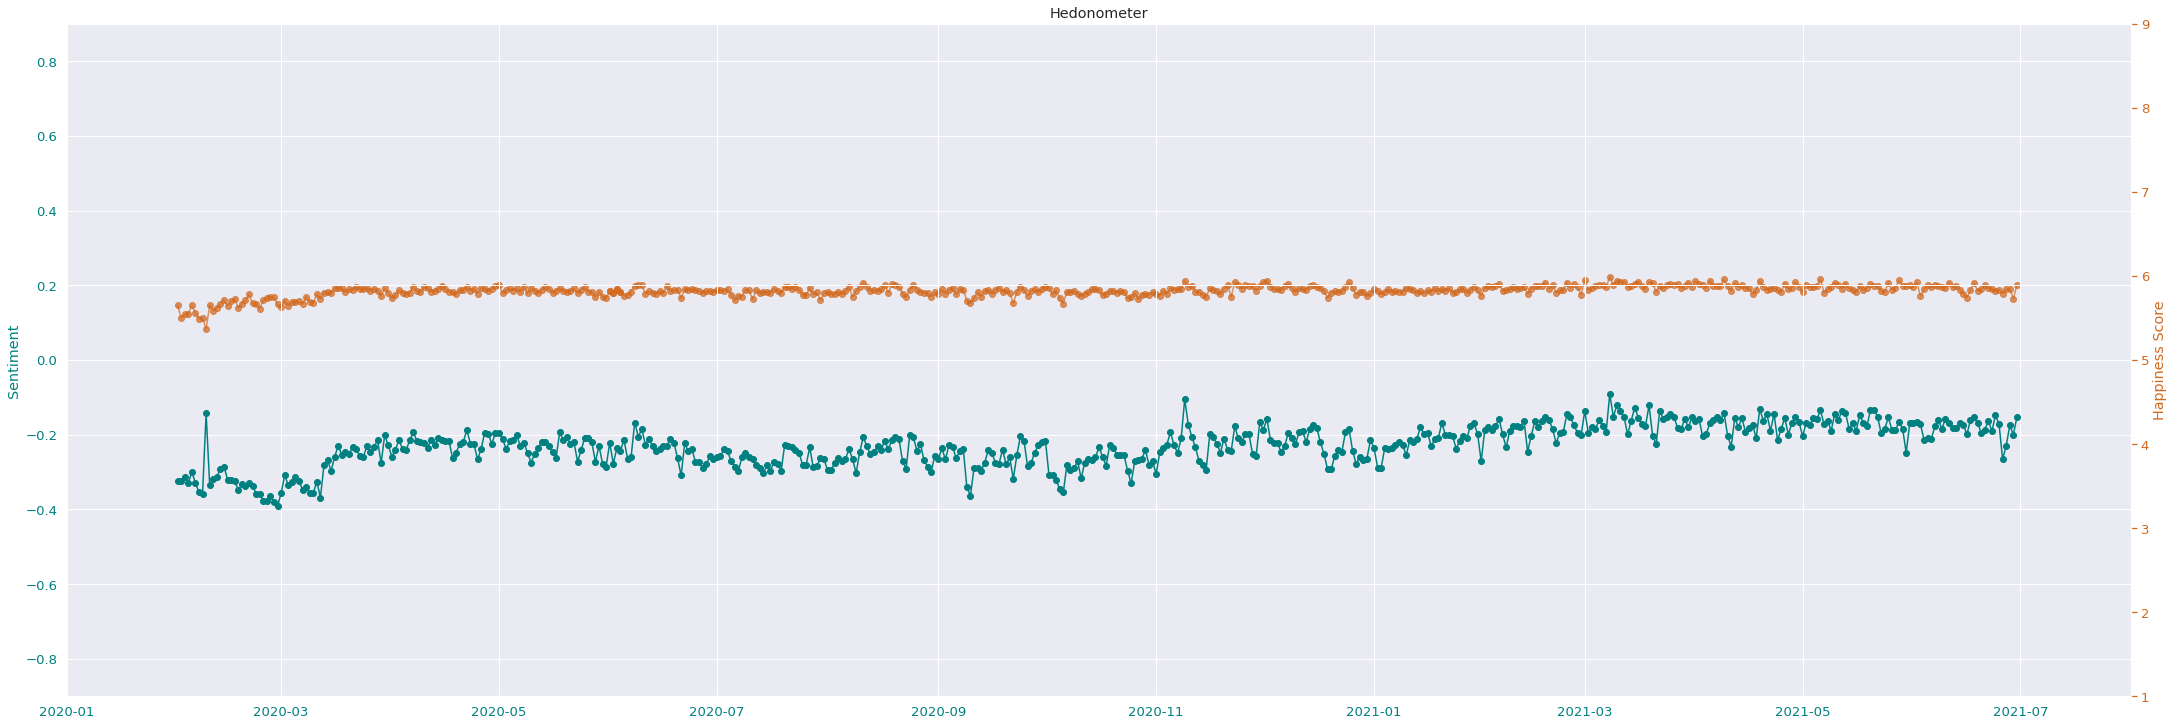

In [ ]:
import matplotlib.pyplot as plt
import datetime

sns.set_style('darkgrid')
fig = plt.figure(figsize=(30,10))

ax3=fig.add_subplot(111, label="3")
ax=fig.add_subplot(111, label="1",frame_on=False)

ax.plot(allgrouped.Datetime,allgrouped.score_norm,color='teal',label='Sentiment of COVID-19 tweets', marker='o')
ax.set_xlabel("", color='teal')
ax.set_ylabel("Sentiment", color='teal')
ax.tick_params(axis='x', colors='teal')
ax.tick_params(axis='y', colors='teal')
ax.set_ylim([-0.9,0.9])
ax.set_xlim([datetime.date(2020, 1, 1),datetime.date(2021, 8, 1)])

ax3.plot(total.index,total.h_score,color='chocolate', alpha=0.7,label='Mean happiness score per day',marker='o')
ax3.set(title='Hedonometer')
ax3.set_ylabel("Happiness Score", color='chocolate')
ax3.set_xticks([])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax3.grid(False)
ax3.set_ylim([1,9])
ax3.tick_params(axis='y', colors='chocolate')
ax3.set_xlim([datetime.date(2020, 1, 1),datetime.date(2021, 8, 1)])


fig.tight_layout(pad=0)
plt.show()

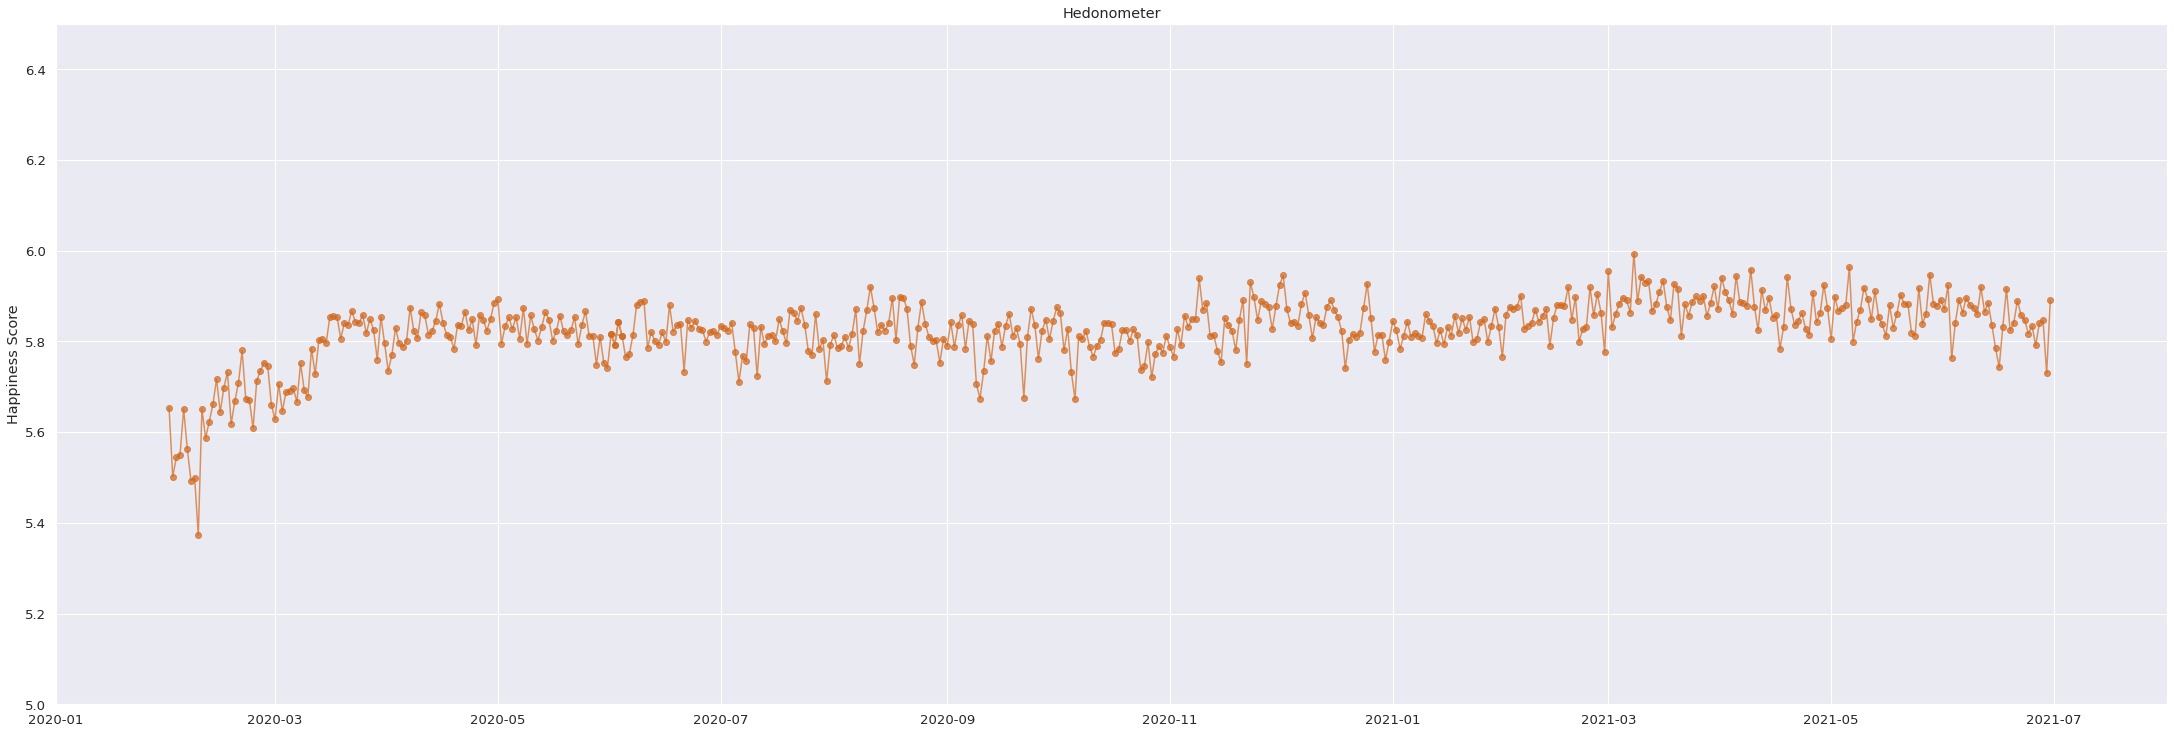

In [ ]:
import matplotlib.pyplot as plt
import datetime

sns.set_style('darkgrid')
fig = plt.figure(figsize=(30,10))

ax3=fig.add_subplot(111, label="3")

ax3.plot(total.index,total.h_score,color='chocolate', alpha=0.7,label='Mean happiness score per day',marker='o')
ax3.set(title='Hedonometer')
ax3.set_ylabel("Happiness Score")

ax3.set_ylim([5,6.5])
ax3.set_xlim([datetime.date(2020, 1, 1),datetime.date(2021, 8, 1)])


fig.tight_layout(pad=0)
plt.show()

#ELON MUSK

In [56]:
elondf = pd.read_csv("/content/drive/MyDrive/NLP/Elon/elonMuskbuysTwitterLABELED.csv",lineterminator='\n') 


In [57]:
elondf['Datetime'] = pd.to_datetime(elondf['Datetime'])
tempElon = elondf[['full_text','Datetime','label','norm01']]
tempElon


,full_text,Datetime,label,norm01
0,@elonmusk @greg16676935420 Twitter wouldn’t be...,2022-04-18 16:19:38,0,0.806344
1,Elon taking control of Twitter will take us fu...,2022-04-18 16:19:36,0,0.861990
2,- Earning interest on your #cryptocurrency. - ...,2022-04-18 16:19:33,1,0.878002
3,Elon Musk posts cryptic ‘Love Me Tender’ tweet...,2022-04-18 16:19:33,1,0.915579
4,→ https://t.co/5uax3pS0R4 Elon Musk posts cry...,2022-04-18 16:19:32,1,0.922353
...,...,...,...,...
942607,@finzfan47 @KenniMiddleton @Elonmusk Hey mr Ju...,2022-04-29 13:31:13,1,0.642765
942608,@elonmusk @waitbutwhy Elon didn’t your dad rap...,2022-04-29 13:30:12,0,0.954689
942609,@davekarpf That's what I LOVE about capitalism...,2022-04-29 13:29:43,2,0.437848
942610,@kriptofon Did you see that Elon Musks brother...,2022-04-29 13:24:18,2,0.884804


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


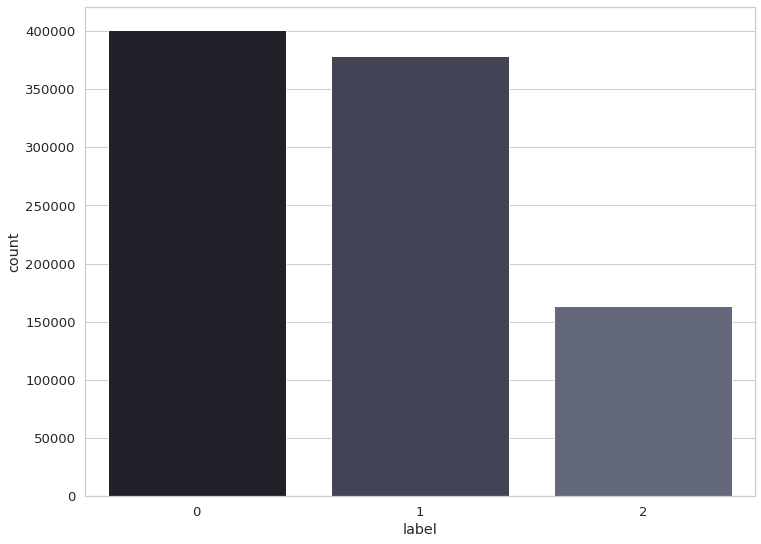

In [58]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

sns.set(style='whitegrid',palette='bone', font_scale=1.2)
sns.countplot(tempElon.label)


## Intensities


In [59]:
tempElon = normalizeScores(tempElon);

clear_output();

In [60]:
rolled = tempElon
rolled['rolling'] = rolled['score_norm'].rolling(window=450).mean()

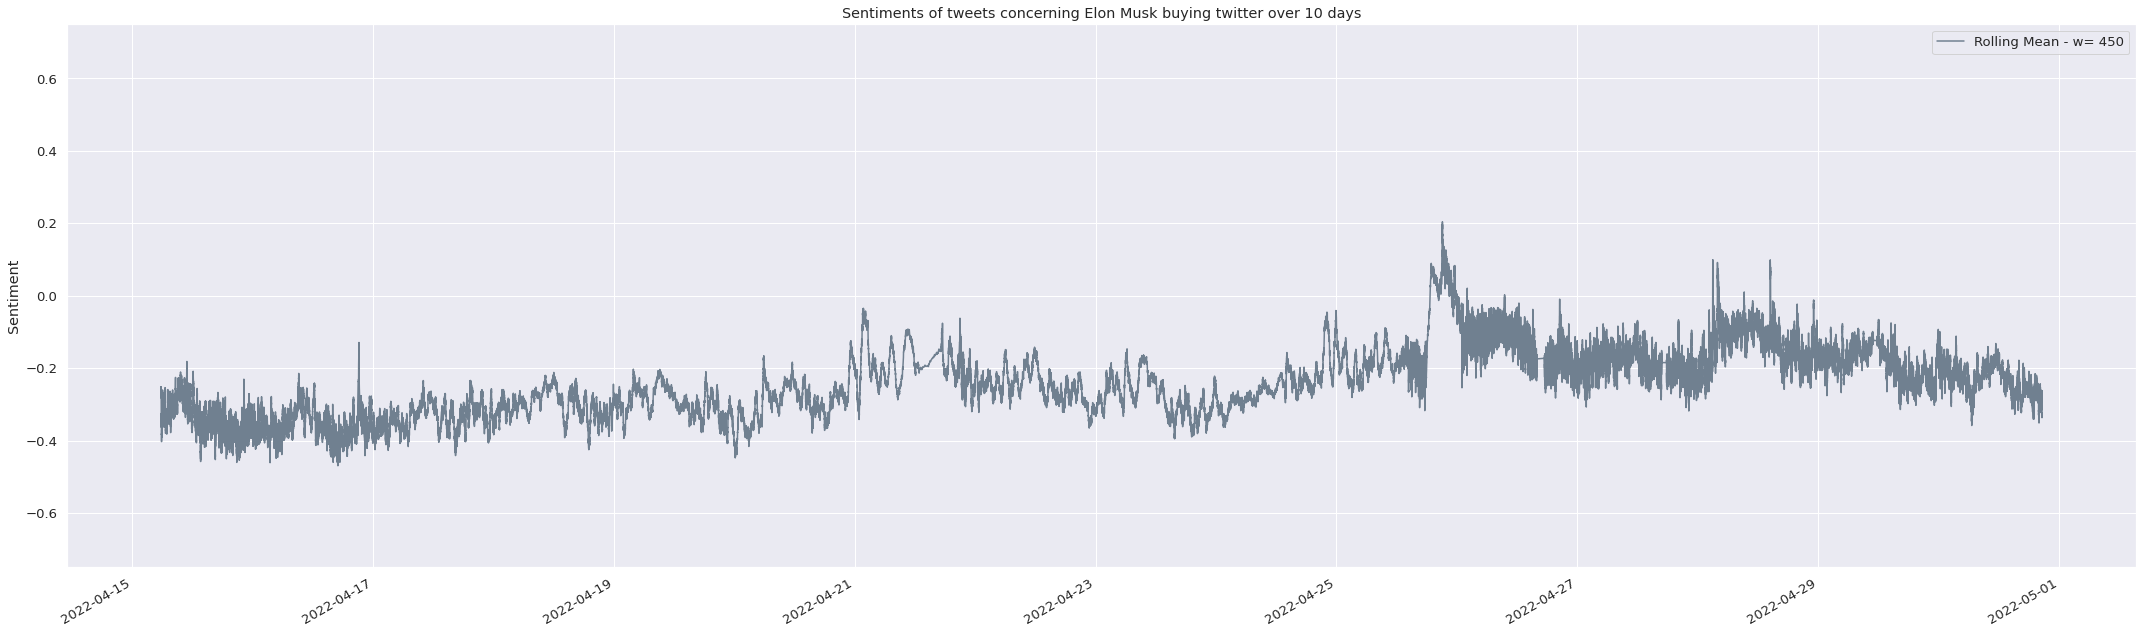

In [61]:
import seaborn as sns

sns.set_style('darkgrid')

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
# ax.scatter(rolled.index,rolled['score_norm'], color='lightgray',label='Tweet Sentiment')
ax.plot(rolled.Datetime,rolled['rolling'], color='slategrey', label='Rolling Mean - w= 450')
ax.set(title='Sentiments of tweets concerning Elon Musk buying twitter over 10 days', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)


# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

In [62]:
tempElon = tempElon.set_index('Datetime')
grouped = tempElon.resample('12H')
allgrouped = grouped.mean().reset_index()
allgrouped["score_norm"] = pd.to_numeric(allgrouped["score_norm"])


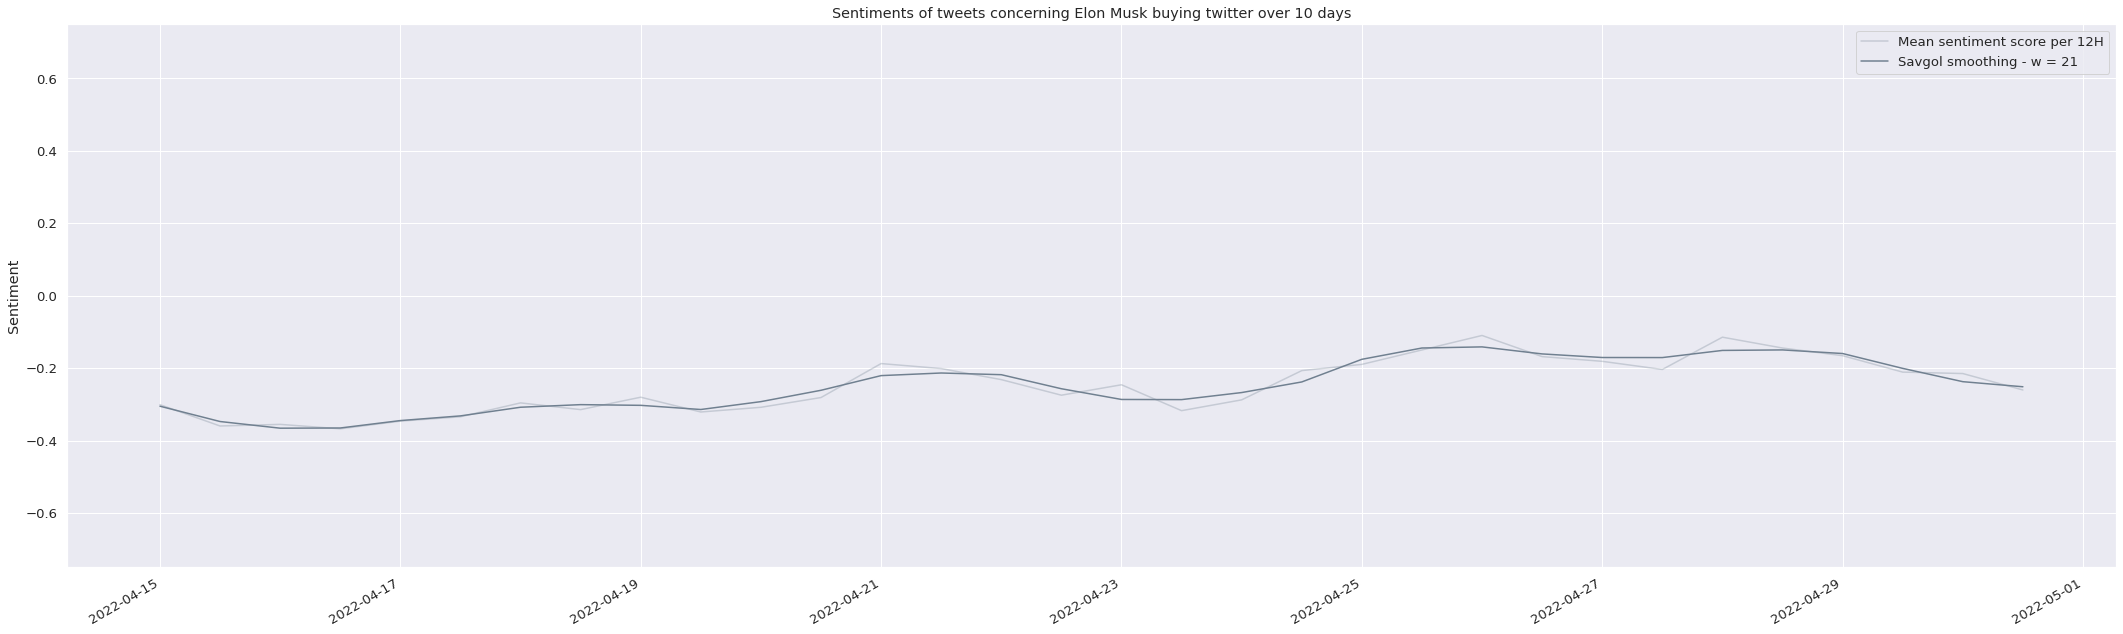

In [63]:

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
ax.plot(allgrouped.Datetime,allgrouped.score_norm,alpha=0.3,color='slategrey', label='Mean sentiment score per 12H')
from scipy.signal import savgol_filter
yhat = savgol_filter(allgrouped.score_norm,7, 3)
ax.plot(allgrouped.Datetime,yhat, color='slategrey', label='Savgol smoothing - w = 21')

ax.set(title='Sentiments of tweets concerning Elon Musk buying twitter over 10 days', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()

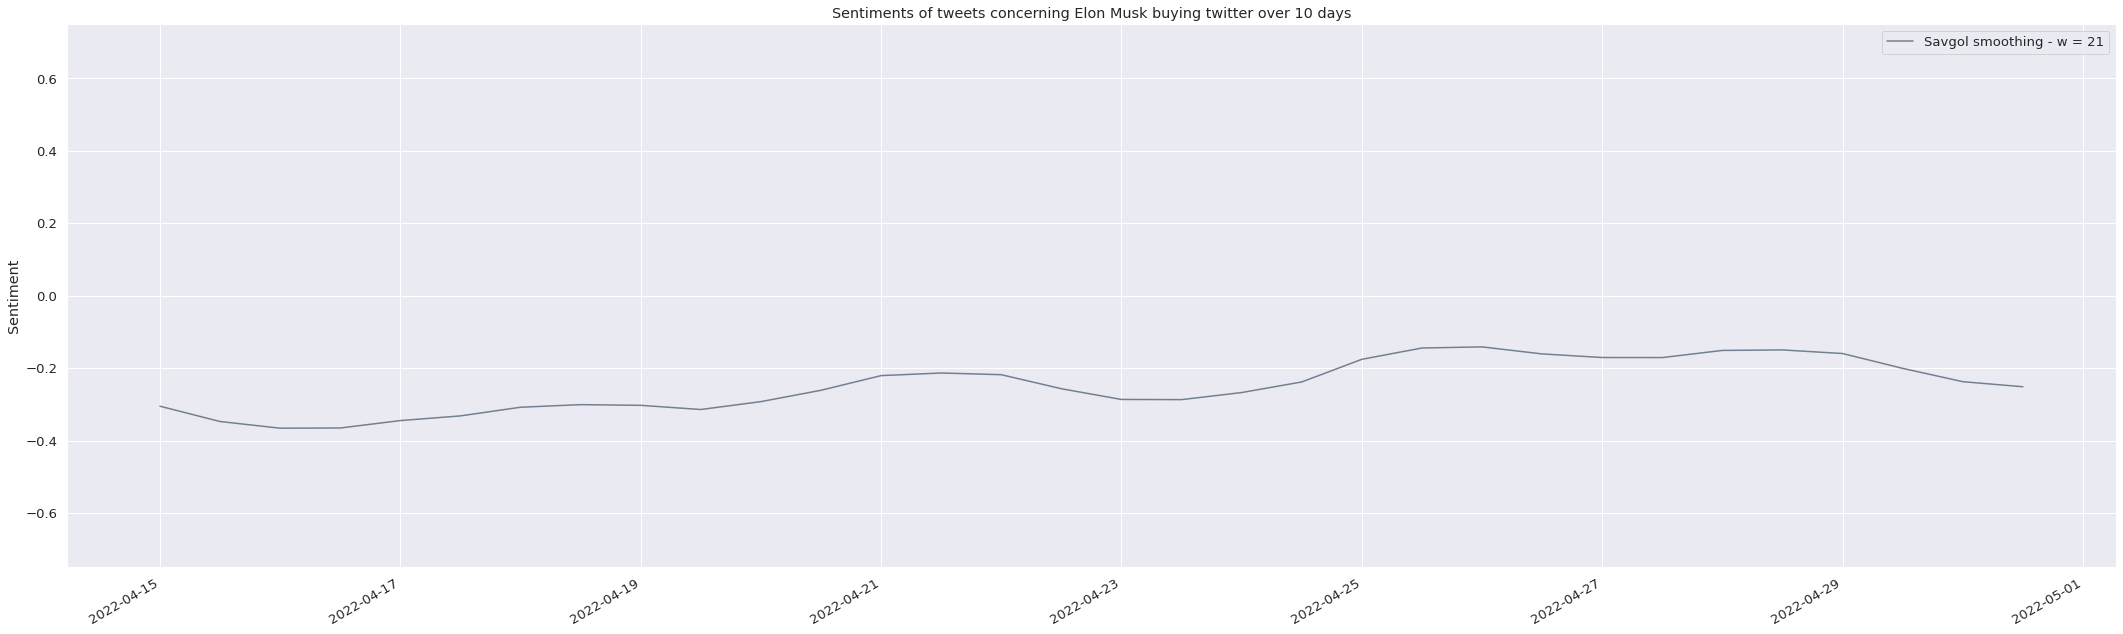

In [64]:

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot()
from scipy.signal import savgol_filter
yhat = savgol_filter(allgrouped.score_norm,7, 3)
ax.plot(allgrouped.Datetime,yhat, color='slategrey', label='Savgol smoothing - w = 21')

ax.set(title='Sentiments of tweets concerning Elon Musk buying twitter over 10 days', ylabel='Sentiment')
ax.legend(loc='best')
fig.tight_layout()
plt.ylim([-0.75,0.75])
plt.grid(True)

# Tell matplotlib to interpret the x-axis values as dates
ax.xaxis_date()

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()
plt.show()